In [3]:
#pip install geopandas

In [5]:
#pip install lightgbm

In [4]:
#import geopandas as gpd
#shape=gpd.read_file('JORDBRUKSBLOCK_2021.shp')
#shape.plot()

In [7]:
#pip install eo-learn

In [9]:
#pip install sentinelsat

In [11]:
#pip install pyproj

# How To: Crop type classification for Sweden

This example notebook shows the steps towards constructing an automated machine learning pipeline for crop type identification in an area of interest in Sweden. Along the pipeline, two different approaches are applied and compared. The first one, the LightGBM, represents a state-of-the-art machine learning algorithm. The second one is a Temporal Convolutional Neural Network architecture from the field of deep learning. The prediction is performed on a time-series of Sentinel-2 scenes from 2018. The example notebook will lead you through the whole process of creating the pipeline, with details provided at each step (see **Overview**). 

## Before start
Enjoying the functionality of eo-learn and the simplicity of this example workflow is preceded by the unavoidable setup of an adequate working environment. But trust us, it's worth it! And we'll take you by the hand.
### Requirements
#### Sentinel Hub account
To run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at the [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at the [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, please follow the instructions at [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) to configure your `sentinelhub` installation. For Processing API request you need to obtain and set your `oauth` client id and secret. 

#### Sentinel Hub Python package
The [Sentinel Hub Python package](https://sentinelhub-py.readthedocs.io/en/latest/) allows users to make OGC (WMS and WCS), and more powerful and versatile Process API web requests to download and process satellite images within your Python scripts. It supports access to all the datasources, including your own data through "Bring Your Own Cogs" functionality of Sentinel Hub services.

#### eo-learn library
Between the acquisition of a satellite image and actionable information, there is a large processing effort. [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html) as a collection of modular Python sub-packages allows easy and quick pro-cessing of spatio-temporal data to prototype, build and automate these required large scale EO workflows for AOIs of any size. It also directly enables the application of state-of-the-art tools for computer vision, machine learning and deep learning packages in Python to the data. Especially for non-experts to the field of remote sensing and machine learning it makes extraction of valuable information from satellite imagery easier and more comfortable.

#### Additional packages
In addition to the previous packages the installation of the packages [keras](https://keras.io/), [tensor flow](https://www.tensorflow.org/) and [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) is required.

## Overview
With the help of the eo-learn library, the entire classification process can be executed in 4 processing blocks, i.e. `EOWorkflows`.
1. Ground truth data
2. EO data
3. Feature engineering - Crop type grouping - Sampling
4. Prediction

**In more detail the notebook is structured as follows:**


I. Imports

II. Configurations
### Part I
1. BBox-Splitter
    - Plot AOI and give the extent
    - Create BBoxes
    - Visualize the selection
2. Add ground truth data
    - Create EOPatches and add LPIS + area ratio
3. Add EO data
    - Choose EO features
    - Clean EOPatch list
4. Feature/ label engineering and Sampling
    - Data visualization
    - Resampling, Interpolation, LPIS data preparation
    - Sampling
    
### Part II

6. Prediction
    - Set up and train LightGBM model
    - Set up and train TempCNN model
    - Model validation and evaluation
    - Prediction
    - Visualization of the results
7. Next steps

Now, after the setup you are curious what is next and can't wait to get your hands dirty? Well, let's get started!

# Imports
Lets start with some necessary imports.

In [12]:
# set module directory to system path
import sys, os
MAIN_FOLDER = os.getcwd()
print(MAIN_FOLDER)
import_path = os.path.join(MAIN_FOLDER, 'Tasks')
if import_path not in sys.path:
    sys.path.append(import_path)

/notebooks/notebooks/AgricultureProject/eo-learn-master/examples/crop-type-classification


In [13]:
# Built-in modules
import math
import shutil
import itertools
from datetime import timedelta
import pyproj

# Basics of Python data handling and visualization
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Polygon
from tqdm.notebook import tqdm


# Imports from eo-learn, sentinelhub-py, and perceptive-sentinel
from sentinelhub import CRS, BBoxSplitter, MimeType, SHConfig, DataSource, DataCollection

from eolearn.core import LinearWorkflow, FeatureType, SaveTask, OverwritePermission, LoadTask
from eolearn.core import EOPatch, EOTask, CreateEOPatchTask, ZipFeatureTask, MapFeatureTask
from eolearn.geometry import VectorToRaster, ErosionTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import SimpleFilterTask, LinearInterpolation
from eolearn.features import NormalizedDifferenceIndexTask, EuclideanNormTask
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask

# Machine learning
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Deep Learning
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.utils import to_categorical

# Notebook specific classes and functions
from CropTypeClassTasks import CleanLPIS, GroupLPIS, LPISCLASS, ConcatenateData, SamplingTaskTask
#from CropTypeClassTasks import RemoveTask
from CropTypeClassTasks import get_patch_list, train_test_split_eopatches, train_test_split_eopatch
from CropTypeClassTasks import plot_confusion_matrix, PredictPatch, AddAreaRatio, FixLPIS, masking
from CropTypeClassTasks import AddGeopediaVectorFeature, Sen2CorValidData, ValidDataFractionPredicate

2021-08-31 10:57:58.284408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 10:57:58.284453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Configurations
In this part you can define your configurations. The basic configurations are set for an example running smoothly.
## Configuration file customization

In [14]:
# In case you put the credentials into the configuration file by hand you can leave this unchanged


In [15]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET and INSTANCE_ID:
    config.instance_id = INSTANCE_ID
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '' or config.instance_id == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")


In [16]:
# from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
# from collections import OrderedDict
 
# api = SentinelAPI('a0s6044', 'Alexandros1!', 'https://scihub.copernicus.eu/dhus/')
 
# #roi = 'POLYGON((DEFINE ROI))' # http://geojson.io/#map=10/42.4012/117.2488
# roi = 'POLYGON((116.94259643554688 42.22648356137063,\
#                 117.61138916015625 42.22648356137063,\
#                 117.61138916015625 42.51867517417283,\
#                 116.94259643554688 42.51867517417283,\
#                 116.94259643554688 42.22648356137063))'
# start_date = '20200101'
# end_date = '20200307'
# product_type = 'S2MSI2A'
# cloud_cover = (0,50)
# products = api.query(area=roi,date=(start_date, end_date),
#                      producttype=product_type,cloudcoverpercentage=cloud_cover)
# #downfiles = OrderedDict()
# for i in products:
#     product = products[i]
#     filename = product['filename']
#     print(filename)
 
#successfile = api.download_all(products)

## Workflow configuration

In [17]:
# define in- and output folders
output_path = os.path.join(MAIN_FOLDER, 'Output')
general_data_path = os.path.join(MAIN_FOLDER, 'GeneralData')
patch_path = os.path.join(MAIN_FOLDER, 'Output', 'EOPatches')
if not os.path.exists(patch_path):
    os.makedirs(patch_path)

thresLPIS_path = os.path.join(MAIN_FOLDER, 'Output', 'EOPatches_Low_LPIS_Thres')
samples_path = os.path.join(MAIN_FOLDER, 'Output', 'Samples')
models_path = os.path.join(MAIN_FOLDER, 'Output', 'Models')
predictions_path = os.path.join(MAIN_FOLDER, 'Output', 'Predictions')

# For reference colormap
lpisclass_cmap = mpl.colors.ListedColormap([entry.color for entry in LPISCLASS])
lpisclass_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 26, 1), lpisclass_cmap.N)
class_names = [entry.class_name for entry in LPISCLASS]
class_ids = [entry.id for entry in LPISCLASS]


### 1. BBox-Splitter
##  Plot AOI and give extent
INPUT_FILE = os.path.join(general_data_path, 'Area_AOI_New.geojson')     # Geojson or Shapefile of the area of interest
#austria = os.path.join(general_data_path, 'Area_AOI_SwedenNew.geojson') #'custom.geo.json') # Sweden
sweden = os.path.join(general_data_path, 'Area_AOI_SwedenNew.geojson')  # Geojson of austrian national borders

#INPUT_FILE = os.path.join(general_data_path, 'Area_AOI_Sweden.geojson') # Geojson or Shapefile of the area of interest
#austria = os.path.join(general_data_path, 'Area_Sweden.geo.json')#'Area_Austria.geojson') # Geojson of austrian national borders
crs = CRS.UTM_33N # 33N # wanted coordinate System of the AOI


### 2. Add ground truth data
## Create EOPatches and add LPIS + area ratio
year = '2019' # year of interest
years= '2018'
layerID_dict = {'2019': 2034, '2017': 2034, '2016': 2033} # Layer IDs of Geopedia Layer
layerID = layerID_dict[year] # Layer ID for Austria of year set by "year"
patch_list = get_patch_list(patch_path) # List of created EOPatches names

### 3. Add EO data
## Choose EO features
maxcloud = 0.8 # maximum cloudcoverage of sentinel tiles used for download
datafrac = 0.7 # keep only frames with valid data fraction over x%
## Clean EOPatch list
lpis_thres = 0.01 # 0.13 # Patches with less than x% of LPIS coverage are excluded in the following
## Add EO data
time_interval = [f'{years}-10-01', f'{year}-07-30'] # the start and end date for downloading satellite data


### 4. Feature and label engineering
## Feature concatenation, interpolation and LPIS data preparation
day_range = 8 # the realtime range of valid satellite images is resampled to a x day equidistant range 
## Prepare LPIS data
grouping_id = 'basic' # define grouping id (has to be identical to endings of the two grouping files)
# File that contains LPIS Crop ID and wanted groups - Colums of shape: CROP_ID, english, slovenian, latin, GROUP_1
lpis_to_group_file = os.path.join(general_data_path, 'at_lpis_{}_crop_to_group_mapping_{}.csv'.format(year, grouping_id))
# File that contains the wanted groups and their ID - Colums of shape: GROUP_1, GROUP_1_ID
crop_group_file = os.path.join(general_data_path, 'crop_group_1_definition_{}.csv'.format(grouping_id))


### 5. Sampling
## Sampling per EOPatch
pixel_thres = 1000 # Pixel thresold necessary for a class to be considered in sampling
samp_class = 500 # take x samples per class per EOPatch
## Combine samples and split into train and test data
test_ratio = 4 # take every xth patch for testing
features_dict = 'NORM'#'FEATURES_SAMPLED' # name of the dictionary where the sample features are saved
labels_dict = 'LPIS_class_{}_ERODED_SAMPLED'.format(grouping_id) # name of the dictionary where the sample labels are saved

In [18]:
sweden_gdf = gpd.read_file(sweden)


# 1. From AOI to BBox

In [19]:
#swedishborder = [[22.854101562500034,68.36733398437502],[22.975390625000045,68.31645507812505],[23.09785156250004,68.25756835937506],[23.18251953125008,68.13662109375002],[23.318554687500065,68.13032226562498],[23.35546875000003,68.08867187500002],[23.474218749999977,68.01733398437504],[23.63886718750004,67.95439453125],[23.632910156249977,67.93320312500003],[23.50185546875002,67.87519531249995],[23.487792968749996,67.79658203125001],[23.500195312500036,67.69619140625],[23.541308593750074,67.61430664062502],[23.53701171875008,67.59038085937502],[23.504492187500034,67.56215820312505],[23.46542968750006,67.51787109374999],[23.451464843750045,67.47919921875001],[23.454882812500045,67.46025390625007],[23.468066406250074,67.449951171875],[23.537109375,67.449169921875],[23.660839843749983,67.44003906250003],[23.733593750000065,67.42290039062497],[23.774902343750057,67.32861328124997],[23.76093750000004,67.31049804687501],[23.656640625000023,67.26782226562503],[23.626074218750006,67.23393554687505],[23.62304687500003,67.18413085937502],[23.64150390625005,67.12939453124997],[23.677343750000063,67.06811523437503],[23.758984375,67.002587890625],[23.86933593750001,66.93403320312498],[23.941796875000023,66.87783203124997],[23.97607421875,66.838232421875],[23.988574218750042,66.81054687500003],[23.93886718750005,66.77573242187505],[23.894140625,66.70688476562506],[23.885839843750006,66.62802734374996],[23.865527343750045,66.57661132812497],[23.768359375000042,66.50585937500004],[23.70117187500003,66.48076171874997],[23.68203125000005,66.44340820312502],[23.673828125000053,66.38071289062503],[23.693554687499983,66.304296875],[23.70029296875003,66.25263671874998],[23.720996093750074,66.21542968750003],[23.75146484374997,66.19116210937497],[23.907324218750034,66.14824218750002],[23.994628906250053,66.06035156250005],[24.04902343750004,65.98984375],[24.15546875000004,65.80527343750006],[23.89052734375008,65.78222656249997],[23.69140625,65.828515625],[23.592089843750017,65.80532226562497],[23.41835937500005,65.80434570312505],[23.221093750000023,65.78613281249997],[23.154589843750074,65.74990234374995],[23.102343750000074,65.73535156250003],[22.919335937499994,65.78647460937503],[22.74658203124997,65.870947265625],[22.62031250000001,65.80654296875005],[22.538574218750053,65.79433593750005],[22.465136718750017,65.85263671875],[22.400976562500006,65.86210937499997],[22.366308593750063,65.84267578125002],[22.3359375,65.79116210937502],[22.28759765625,65.75063476562502],[22.275,65.725],[22.266601562499996,65.62153320312501],[22.254003906250006,65.59755859375002],[22.086230468750017,65.61093749999998],[22.096289062500002,65.58378906250005],[22.1328125,65.57011718750002],[22.147558593750063,65.55288085937497],[22.086718750000017,65.53022460937498],[21.92011718750001,65.53237304687497],[21.903125,65.50834960937505],[21.95,65.47036132812502],[21.91347656250008,65.437109375],[21.87958984375001,65.42402343750001],[21.680664062499996,65.40336914062507],[21.565527343750063,65.40810546874995],[21.532617187500023,65.386572265625],[21.52343750000003,65.35859375000001],[21.545214843750017,65.33115234375],[21.595996093750045,65.31655273437495],[21.61269531250008,65.29912109375005],[21.609179687500074,65.261376953125],[21.56689453125,65.25454101562502],[21.446875,65.32084960937505],[21.410351562500068,65.31743164062505],[21.43779296875007,65.28295898437506],[21.50634765625,65.24536132812503],[21.545996093750006,65.20698242187501],[21.580664062500034,65.16079101562502],[21.57392578125001,65.12578124999999],[21.424902343750002,65.01269531250006],[21.29375,64.94125976562498],[21.195898437500006,64.87690429687501],[21.138183593750057,64.80869140625006],[21.20498046875008,64.77431640625],[21.27929687500003,64.72470703125],[21.33154296875,64.62934570312501],[21.39384765624999,64.54433593750002],[21.519628906250034,64.46308593749998],[21.494335937500036,64.41611328125],[21.46503906250001,64.37958984375004],[21.255761718750023,64.29916992187499],[21.01845703125008,64.17797851562499],[20.76269531250003,63.86782226562505],[20.677636718750023,63.826269531250006],[20.453710937500034,63.773730468750074],[20.371386718750074,63.72290039062499],[20.204687500000034,63.66245117187503],[19.913671875000063,63.61054687500004],[19.78164062500008,63.538183593750034],[19.722070312500023,63.463330078124976],[19.655761718750025,63.45800781250006],[19.59003906250004,63.48725585937495],[19.502343750000023,63.50903320312505],[19.49091796875001,63.46020507812505],[19.494628906250057,63.42436523437502],[19.354296875000074,63.47749023437501],[19.2880859375,63.428759765625045],[19.236328125,63.34736328124998],[19.034375,63.23774414062501],[18.816699218750045,63.257470703125044],[18.792285156250042,63.238134765625],[18.850195312500034,63.22412109375],[18.85898437500006,63.20659179687499],[18.819433593749977,63.19726562500002],[18.759570312500045,63.19824218749998],[18.667187500000068,63.17656249999998],[18.60644531250003,63.17827148437499],[18.57763671875003,63.12641601562499],[18.53066406250005,63.06352539062504],[18.407714843750057,63.0375],[18.34423828125,63.03212890624996],[18.31289062500008,62.996386718750045],[18.502050781249977,62.98886718750003],[18.486914062500006,62.95859375],[18.48261718750004,62.928320312500034],[18.46308593750004,62.895849609375006],[18.24804687500003,62.849072265624976],[18.214941406250034,62.81220703125001],[18.170019531250034,62.789355468750074],[18.07441406250001,62.790673828124994],[18.077929687500014,62.81196289062496],[18.093554687500074,62.83603515624998],[17.951074218749994,62.833886718749994],[17.906640625000023,62.88676757812502],[17.87958984375001,62.873193359374994],[17.895605468749977,62.83051757812501],[17.932910156250045,62.78613281250003],[17.974414062500045,62.721044921875006],[17.940722656250017,62.679882812499976],[17.903027343750068,62.65947265624998],[17.930468750000074,62.640625],[18.006542968750036,62.626269531250074],[18.037304687500068,62.60053710937498],[17.947070312500074,62.578466796875],[17.834472656250057,62.50273437500002],[17.7177734375,62.50087890624999],[17.646386718750023,62.45087890625004],[17.570605468750045,62.45102539062498],[17.50898437500001,62.48251953125],[17.410253906250063,62.508398437500034],[17.378417968750053,62.46279296874996],[17.373339843750074,62.42651367187505],[17.429003906250045,62.33471679687499],[17.53525390625003,62.263671875],[17.633691406249994,62.23300781250006],[17.56289062500005,62.21230468750002],[17.510156250000048,62.16630859375005],[17.446582031250074,62.02265625],[17.41201171875005,61.966113281250045],[17.374511718750057,61.86630859375003],[17.39824218749999,61.782080078125034],[17.41728515625007,61.74067382812505],[17.465429687500006,61.684472656250044],[17.334570312500006,61.69169921874999],[17.196386718750006,61.72456054687503],[17.215625,61.656347656250006],[17.13076171875005,61.57573242187498],[17.146582031250063,61.50463867187499],[17.16425781250004,61.45830078125004],[17.137988281250017,61.381689453125006],[17.177929687500068,61.35761718749998],[17.199609375000023,61.31196289062501],[17.163867187500045,61.278271484374976],[17.179785156250006,61.24926757812503],[17.18574218750004,61.146533203125045],[17.212890625,60.98583984374999],[17.20292968749999,60.95185546875001],[17.278906250000034,60.81215820312497],[17.261230468750057,60.76318359375003],[17.25097656250003,60.70078125],[17.35986328125,60.640820312499955],[17.45703125,60.641796874999976],[17.555468750000045,60.64272460937499],[17.593066406250074,60.62768554687503],[17.630761718750023,60.58525390625002],[17.6611328125,60.53515625000002],[17.7421875,60.53930664062497],[17.871582031250057,60.58007812500002],[17.955761718750068,60.589794921874955],[18.011328125000034,60.511425781249976],[18.1625,60.40791015625004],[18.250488281249996,60.361523437499976],[18.4,60.33710937499998],[18.557519531250023,60.25356445312502],[18.535449218750045,60.152880859375024],[18.601171875000034,60.11923828125],[18.78701171875005,60.0794921875],[18.85273437500001,60.02587890625],[18.884277343750057,59.98017578125001],[18.933203124999977,59.942285156250016],[18.99042968750001,59.82778320312496],[18.970507812500045,59.757226562499994],[18.895605468750063,59.73295898437501],[18.71875,59.65737304687496],[18.639941406250017,59.600927734375034],[18.578125,59.56577148437506],[18.402441406250034,59.49038085937496],[18.338085937500065,59.47685546875007],[18.276464843750034,59.437646484374966],[18.216894531250063,59.420507812500034],[18.163574218750057,59.43037109375001],[17.964257812500023,59.359375],[17.97978515625007,59.329052734374976],[18.132617187500045,59.31621093750002],[18.210546875000034,59.331445312500016],[18.27050781249997,59.36713867187502],[18.336035156250006,59.37534179687498],[18.395800781250017,59.36860351562504],[18.45917968750004,59.39672851562499],[18.508886718750063,59.407958984374964],[18.56025390625004,59.39448242187499],[18.61757812500008,59.32705078124999],[18.498632812500006,59.291943359374955],[18.41425781250004,59.29033203124998],[18.373046875,59.179736328125024],[18.321972656250068,59.13222656250002],[18.285351562500068,59.109375],[18.09814453125003,59.06230468749999],[17.974609375,59.00263671874998],[17.829003906249994,58.95458984374997],[17.765429687500017,58.96503906249998],[17.66962890625004,58.916210937499976],[17.45673828125001,58.85839843749999],[17.34765625,58.78051757812502],[17.102832031250042,58.71083984374997],[16.978125,58.65415039062506],[16.63935546875004,58.651171875000074],[16.315820312500023,58.66362304687502],[16.214257812500023,58.636669921874955],[16.31806640625004,58.62832031250002],[16.39082031250001,58.601855468750045],[16.478027343750025,58.612890625],[16.68300781250005,58.599658203125045],[16.788476562500023,58.58525390625004],[16.92382812499997,58.492578125],[16.824316406250063,58.45961914062503],[16.651953125,58.43432617187502],[16.716601562500045,58.302880859374994],[16.76992187500008,58.21425781249996],[16.70009765625005,58.16079101562499],[16.69492187500006,57.917529296874996],[16.596972656250017,57.91289062500005],[16.555371093750068,57.81225585937505],[16.586230468750045,57.76093749999998],[16.583789062500074,57.641748046875044],[16.604199218750068,57.568310546875004],[16.65224609375008,57.50068359374998],[16.63085937499997,57.43017578124999],[16.47597656250005,57.26513671875006],[16.479492187500057,57.187695312499976],[16.50732421875003,57.141699218750034],[16.527929687500063,57.06816406249999],[16.45751953125003,56.92680664062495],[16.4078125,56.808691406250055],[16.348730468750063,56.70927734374996],[16.21650390625004,56.589990234374994],[16.150683593750045,56.500830078125034],[15.996679687500006,56.22260742187501],[15.92031250000008,56.167382812499966],[15.826660156250028,56.12495117187501],[15.722265625000063,56.16420898437502],[15.6265625,56.18559570312504],[15.509667968749994,56.18300781250005],[15.3265625,56.150830078124955],[15.051171875000023,56.17221679687506],[14.782031250000015,56.16191406250002],[14.713964843750004,56.13413085937503],[14.754785156250051,56.03315429687498],[14.655566406249987,56.019921875000016],[14.558593750000057,56.04863281250002],[14.473242187500064,56.014355468749955],[14.401953125000032,55.97675781250004],[14.261914062500011,55.88754882812497],[14.21503906250004,55.83261718749998],[14.202929687500074,55.72915039062502],[14.276464843750034,55.636376953124966],[14.341699218749994,55.52773437500002],[14.173730468750078,55.39663085937496],[14.079980468750051,55.392187500000034],[13.806347656250011,55.428564453125],[13.321386718750063,55.34638671875004],[12.88583984375006,55.41137695312506],[12.940625,55.48159179687505],[12.938769531250017,55.53320312499999],[12.963378906250057,55.61259765625001],[12.97802734375,55.69379882812504],[12.973925781250074,55.74814453125],[12.941992187500034,55.806054687499994],[12.834570312500006,55.88183593750006],[12.592578124999989,56.137597656250016],[12.52099609374997,56.245556640624976],[12.471191406250055,56.29052734375],[12.507031250000068,56.29296874999997],[12.706347656250074,56.235009765624966],[12.752832031250051,56.242138671875004],[12.80166015625005,56.26391601562499],[12.7421875,56.346875],[12.691113281250011,56.38442382812505],[12.65644531250004,56.440576171875016],[12.77314453125001,56.45576171875001],[12.857421875000028,56.45239257812503],[12.91953125,56.515576171875004],[12.883691406250051,56.61772460937496],[12.793164062500011,56.64916992187497],[12.717578125000072,56.662841796875],[12.572656250000023,56.82329101562502],[12.421484375000034,56.90639648437496],[12.15185546875,57.22695312499999],[12.053222656249972,57.446972656249976],[11.961523437500034,57.42607421874999],[11.916992187500028,57.521923828124955],[11.885058593750017,57.61269531249999],[11.878710937500045,57.67944335937499],[11.734960937500063,57.717675781249966],[11.729101562500034,57.76445312499999],[11.703222656250006,57.97319335937495],[11.549023437500038,58.001220703125],[11.449316406250063,58.11835937499995],[11.43154296875008,58.339990234374994],[11.32998046875008,58.38032226562495],[11.24824218750004,58.369140625],[11.252050781250006,58.424072265625],[11.271582031250006,58.47563476562502],[11.22382812500004,58.679931640624964],[11.20791015625008,58.866406249999955],[11.169140624999981,58.92270507812506],[11.14716796875004,58.98862304687497],[11.16689453125008,59.04555664062502],[11.19580078125,59.07827148437505],[11.295312500000023,59.086865234375004],[11.388281250000063,59.03652343749996],[11.470703125000057,58.90952148437503],[11.543554687500063,58.893017578124955],[11.64277343750004,58.926074218750024],[11.712207031250045,59.01865234374998],[11.75185546875005,59.15756835937503],[11.798144531250072,59.28989257812498],[11.743359375000011,59.431445312500045],[11.684863281250074,59.55576171874998],[11.680761718750032,59.59228515625002],[11.834277343750044,59.697167968749994],[11.88125,59.78247070312497],[11.93212890625,59.86367187499999],[11.98828125,59.89130859375004],[12.071875,59.897607421874994],[12.169238281250074,59.91289062499999],[12.291992187500057,59.96723632812495],[12.402050781249981,60.04003906250006],[12.486132812500074,60.106787109375055],[12.514648437500028,60.23886718750006],[12.515820312499983,60.305224609375074],[12.552832031250063,60.35449218749997],[12.588671874999989,60.450732421875045],[12.553808593750006,60.54565429687502],[12.445312500000027,60.68964843749995],[12.314648437500038,60.89213867187498],[12.294140625000038,61.00268554687506],[12.353710937500011,61.023193359374964],[12.467578125000017,61.041503906249964],[12.683007812500021,61.04682617187498],[12.706054687500028,61.059863281250074],[12.727832031250017,61.10825195312497],[12.776367187500057,61.17397460937505],[12.828222656250034,61.22182617187502],[12.86367187500008,61.29028320312503],[12.88076171875008,61.35229492187506],[12.75751953125004,61.44570312499997],[12.59609375,61.54130859375001],[12.486816406250028,61.57299804687497],[12.292089843750063,61.653466796875016],[12.155371093750004,61.720751953125045],[12.233691406250074,61.97685546875001],[12.291992187500057,62.16743164062501],[12.301367187500006,62.213769531250044],[12.303515625000074,62.28559570312501],[12.114550781250045,62.59189453124998],[12.121875,62.660009765625006],[12.13984375000004,62.72133789062496],[12.11962890625,62.82592773437497],[12.108593750000068,62.91948242187501],[12.141015625000023,62.94785156250003],[12.218164062500023,63.000634765625016],[12.144628906250034,63.08251953125002],[12.138671874999972,63.089160156250045],[11.99990234375005,63.291699218750004],[12.212109375000011,63.49223632812498],[12.17519531250005,63.59594726562499],[12.30195312500004,63.671191406250045],[12.532714843750057,63.84355468749999],[12.6625,63.94047851562502],[12.690039062500032,63.95742187499999],[12.792773437500017,64],[12.987597656250017,64.05048828124995],[13.203515625000023,64.07509765625],[13.299609375000074,64.07480468750003],[13.670703125000074,64.040625],[13.960546875000063,64.01401367187498],[14.002734375000044,64.04072265625001],[14.063281250000045,64.09550781250007],[14.141210937500006,64.17353515624998],[14.148046874999977,64.26030273437507],[14.119921875000017,64.38774414062502],[14.077636718750028,64.46401367187498],[13.873535156250028,64.51357421874997],[13.650292968750023,64.58154296874997],[13.92480468749997,64.79677734375001],[14.115136718750023,64.946142578125],[14.352441406250051,65.17084960937504],[14.42626953125,65.26435546874998],[14.479687500000038,65.30146484374998],[14.549511718750068,65.64638671875002],[14.595800781249977,65.74287109374995],[14.634570312500074,65.79326171874999],[14.635156250000023,65.84501953125007],[14.609960937500036,65.932275390625],[14.543261718750044,66.12934570312498],[14.91796875,66.1537109375],[15.0400390625,66.16752929687503],[15.153320312500057,66.19106445312505],[15.37490234375008,66.25205078125002],[15.483789062500051,66.30595703124999],[15.422949218750006,66.48984374999996],[15.55703125000005,66.55209960937506],[15.884179687500021,66.76884765625007],[16.23769531250008,66.97641601562498],[16.40351562500004,67.05498046875002],[16.420703125000074,67.093359375],[16.434277343749983,67.15507812500007],[16.360644531249985,67.25200195312499],[16.281542968750045,67.31206054687506],[16.12744140625,67.42583007812507],[16.193554687500068,67.50517578125006],[16.30712890625003,67.52060546875],[16.457128906250034,67.55175781250006],[16.57412109375005,67.61958007812501],[16.585546874999974,67.62832031250002],[16.783593750000023,67.89501953125],[17.170507812500063,68.03012695312498],[17.324609375000023,68.10380859374999],[17.564746093750074,68.04843749999998],[17.916699218750008,67.96489257812502],[18.073242187500025,68.08784179687501],[18.125,68.133447265625],[18.17666015625005,68.20063476562498],[18.15595703125001,68.31684570312495],[18.14707031250006,68.46777343749997],[18.16259765625003,68.52841796874998],[18.303027343750045,68.55541992187497],[18.378613281250068,68.56240234374997],[18.769824218750017,68.50004882812507],[18.868261718749977,68.50112304687502],[19.05263671875008,68.49272460937499],[19.25898437500001,68.46533203125],[19.691210937500045,68.39243164062498],[19.87001953125005,68.36225585937497],[19.969824218750063,68.35639648437501],[20.055957031250014,68.39038085937503],[20.240039062500042,68.4775390625],[19.96884765625003,68.54204101562502],[20.147460937499996,68.60732421875],[20.240039062500042,68.67314453125007],[20.31943359375003,68.75405273437502],[20.348046875000023,68.84873046875002],[20.33710937500001,68.89965820312503],[20.282324218750034,68.934326171875],[20.116699218750057,69.02089843750005],[20.491992187500017,69.03330078124998],[20.622167968750006,69.036865234375],[20.895117187500006,68.97983398437502],[20.907031250000014,68.96748046874998],[20.908984375000074,68.93774414062497],[20.91855468750006,68.90693359375001],[21.183398437500017,68.82880859374998],[21.25976562500003,68.787451171875],[21.42236328125003,68.72460937499997],[21.465429687500002,68.69067382812499],[21.616015625000045,68.6509765625],[21.724023437500023,68.60854492187497],[21.850195312500063,68.57412109374997],[21.99746093750005,68.52060546874998],[22.195117187500074,68.477978515625],[22.362109375000074,68.46406250000001],[22.78242187500001,68.39101562499995],[22.854101562500034,68.36733398437502]]

In [20]:
# temp = Polygon(swedishborder)
# #temp = austria_gdf.iloc[0, -1]
# #= { "type": "Polygon", "coordinates": [ [ [ 643385.85506086727, 5385280.3887563152 ], [ 644204.54696489696, 5380099.7684315853 ]]]}
# # Get the geometry
# temp = austria_gdf.iloc[0, -1]
# temp.bounds
# #list(temp.exterior.coords)

In [21]:
#import pyproj

# from shapely.geometry import Point, Polygon
# from shapely.ops import transform

# #wgs84_pt = Point(-72.2495, 43.886)
# wgs84_pt = Point(61.314114787189865, 15.41654616828904)
# #new_pt = Point(720944.1103566973, 4862889.031679546)
# #temp = [[ 643385.85506086727, 5385280.3887563152 ], [ 644204.54696489696, 5380099.7684315853 ], [ 643849.8777857793, 5378693.4487119084 ], [ 643705.54535142495, 5378121.3832206484 ], [ 642524.98639591283, 5376809.756811996 ], [ 641328.83184055402, 5375794.0027501425 ], [ 640805.50648565008, 5374732.038873001 ], [ 640453.00238360674, 5373243.3320890442 ], [ 638589.66534222919, 5370409.9297692953 ], [ 637877.54589711723, 5368895.3927087197 ], [ 637610.53302607406, 5367299.8159629088 ], [ 637096.74657580489, 5361350.6472891718 ], [ 636922.39123705553, 5360645.299957196 ], [ 636746.70963313698, 5360310.6096742172 ], [ 636628.79353915551, 5359802.033883946 ], [ 636612.25512760587, 5358580.4033050071 ], [ 636858.02375354792, 5357916.8011146542 ]]

# #new_pt = [temp[pt] for pt in range(len(temp))]
# wgs84 = pyproj.CRS('EPSG:4326')
# utm = pyproj.CRS('EPSG:32633')

# #project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
# project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
# utm_point = transform(project, temp)#
# #utm_point = transform(project, wgs84_pt)
# print(utm_point)


In [22]:
# Convert into list
#templist = list(utm_point.exterior.coords)
#templist

In [19]:
UTM33N=pyproj.CRS("EPSG:32633")

# Define a projection with Proj4 notation, in this case an Icelandic grid 
#isn2004=pyproj.CRS("+proj=lcc +lat_1=64.25 +lat_2=65.75 +lat_0=65 +lon_0=-19 +x_0=1700000 +y_0=300000 +no_defs +a=6378137 +rf=298.257222101 +to_meter=1") 
  
# Define some common projections using EPSG codes 
#wgs84=pyproj.CRS("EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth 
#osgb36=pyproj.CRS("EPSG:27700") # UK Ordnance Survey, 1936 datum 
#UTM26N=pyproj.CRS("EPSG:32626") # UTM coords, zone 26N, WGS84 datum 
#UTM27N=pyproj.CRS("EPSG:32627") # UTM coords, zone 27N, WGS84 datum 
 # ... you get the picture  
#pyproj.transform(UTM33N, wgs84, 390593.908858275, 6162611.91467532) 

In [24]:
#pyproj.transform(UTM33N, wgs84, 390593.908858275, 6162611.91467532) 

In [25]:
#pyproj.transform(wgs84, isn2004, 63.983, -19.700) 

In [26]:
# import shapely.wkt
# import shapely.geometry
# import pyproj
# from shapely.geometry import Point, Polygon
# from shapely.ops import transform

# wgs84 = pyproj.CRS('EPSG:4326')
# utm = pyproj.CRS('EPSG:32618')

# #project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
# project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform


# # Get the geometry
# #temp = austria_gdf.iloc[0, -1]
# temp =  Polygon([[21.99746093750005,68.52060546874998], [21.09746093750005,67.30060546874998], [19.99746093750005,67.20000546874998], [20.09746093750005,68.41060546874998], [21.99746093750005,68.52060546874998]])

# # Now tranform to wgs84
# utm_point = transform(project, temp)#wgs84_pt)

# utm_point

# # Extract the point values that define the perimeter of the polygon
# #x, y = temp.exterior.coords.xy

# # Convert into list
# templist = list(utm_point.exterior.coords)

In [27]:
# def coord_lister(geom):
#     coords = list(geom.exterior.coords)
#     return (coords)

# coordinates = shapely.geometry(temp)

# print( shapely.geometry.MultiPolygon(list_polygons) )

## Plot AOI and give extent
Spotlight on your "INPUT_FILE" configuration! This is where you have the possibility to easily adapt the workflow to your needs. **Take your pick** and replace the AOI file in the _General data_ folder. Either shapefile or geojson formatted version of your AOI is split into smaller patches by `eo-learn`. The total number of patches depends on the AOIs size. Automated splitting is supposed to create patches of size 10 x 10 km. 

In [28]:
# points = []
# for polygon in new_pt:
#     points.extend(polygon.exterior.coords[:-1])

388173.6 6161829.1 421796.0 6173904.3
The extent of the AOI is 33622m x 12075m, so it is split into a grid of 3 x 1.


<AxesSubplot:>

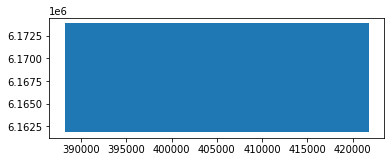

In [20]:
# define Area of interest
aoi = gpd.read_file(INPUT_FILE) # read AOI file

aoi_shape = aoi.geometry.values[-1] # get aoi shape

# define BBox-Splitter split values
ShapeVal_a = round(aoi_shape.bounds[2] - aoi_shape.bounds[0])
ShapeVal_b = round(aoi_shape.bounds[3] - aoi_shape.bounds[1])

#ShapeVal_a = haversine_distance(aoi_shape.bounds[2], 0, aoi_shape.bounds[0], 0)
#ShapeVal_b = haversine_distance(0, aoi_shape.bounds[3], 0, aoi_shape.bounds[1])

#haversine_distance(start_lat, start_lon, row.Lat, row.Lon)

print(aoi_shape.bounds[0],aoi_shape.bounds[1],aoi_shape.bounds[2],aoi_shape.bounds[3])

SplitVal_a = max(1, int(ShapeVal_a/1e4))
SplitVal_b = max(1, int(ShapeVal_b/1e4))

# Give extent of AOI + grid count and plot AOI

print('The extent of the AOI is {}m x {}m, so it is split into a grid of {} x {}.'.format(ShapeVal_a, 
                                                                                          ShapeVal_b, 
                                                                                          SplitVal_a, 
                                                                                          SplitVal_b))

aoi.plot()
#plt.axis('off');

## Create BBoxes
The simple patch polygons are transformed into bounding boxes suitable for serving as geometrical EOPatch frame. 

In [21]:
# split area of interest into an appropriate number of BBoxes
bbox_splitter = BBoxSplitter([aoi_shape], crs, (SplitVal_a, SplitVal_b))

bbox_list = np.array(bbox_splitter.get_bbox_list()) # get list of BBox geometries
info_list = np.array(bbox_splitter.get_info_list()) # get list of x (column) and y(row) indices

print('Each bounding box also has some info how it was created.\nExample:\n'
      'bbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
info: {'parent_bbox': BBox(((388173.6, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633')), 'index_x': 0, 'index_y': 0}



## Visualize the selection
First visualize the GeoDataFrame of the bounding boxes

In [22]:
# create GeoDataFrame of BBoxes
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list] # get geometry from bbox_list for creating GeoSeries

idxs_x = [info['index_x'] for info in info_list] # get column index for naming EOPatch
idxs_y = [info['index_y'] for info in info_list] # get row index for naming EOPatch
#print(info['index_x'])
print(info_list)

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y},
                       crs=crs.pyproj_crs(),
                       geometry=geometry)

shapefile_name = os.path.join(output_path, 'BBoxes.shp')
gdf.to_file(shapefile_name)

#gdf.iloc[2,:]

[{'parent_bbox': BBox(((388173.6, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633')), 'index_x': 0, 'index_y': 0}
 {'parent_bbox': BBox(((388173.6, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633')), 'index_x': 1, 'index_y': 0}
 {'parent_bbox': BBox(((388173.6, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633')), 'index_x': 2, 'index_y': 0}]


Second visualize the split AOI with reference to Swedish national borders

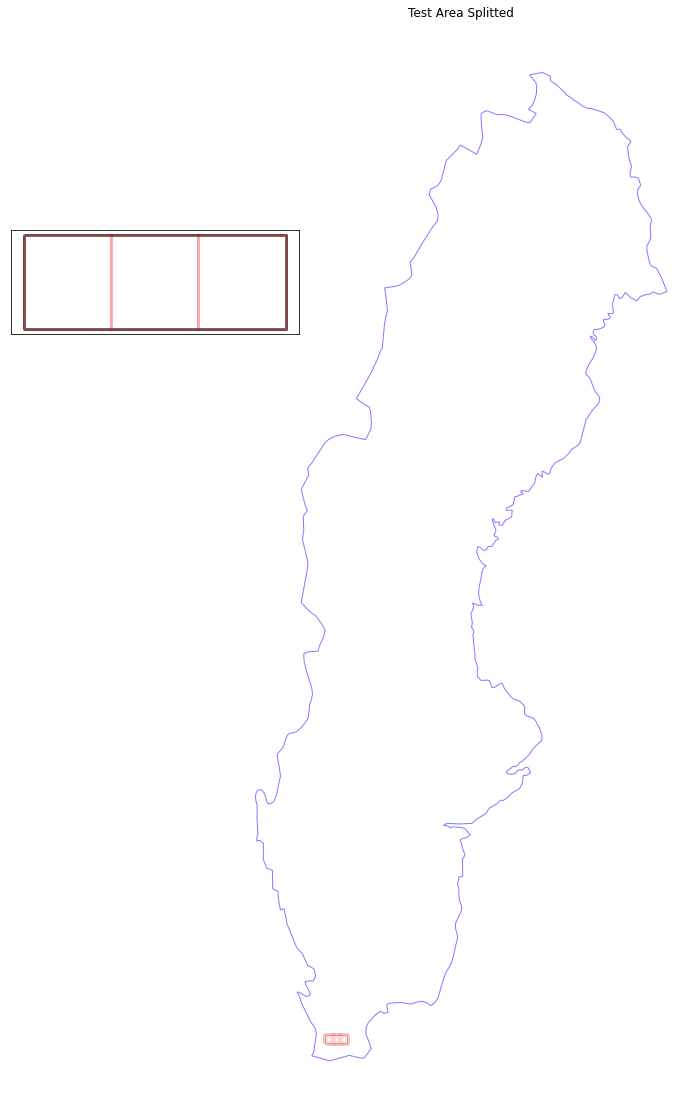

In [23]:
# Plot AOI overview
sweden_gdf = gpd.read_file(sweden)

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 3

# main figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5,linewidth=5)
aoi.plot(ax=ax, facecolor='w',edgecolor='k',alpha=0.5)
#utm_point.plot(ax=ax, facecolor = 'w', edgecolor='g', alpha=0.5)
sweden_gdf.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Test Area Splitted');
plt.axis('off')

# sub figure
a = plt.axes([0.2, 0.6, .2, .2])
gdf.plot(ax=a, facecolor='w',edgecolor='r',alpha=0.5, linewidth=3)
aoi.plot(ax=a, facecolor='w',edgecolor='k',alpha=0.5, linewidth=3)
plt.xticks([]);
plt.yticks([]);

# 2. Add ground truth data

## Create EOPatches and add LPIS data + area ratio
Now it's time to create `EOPatches` and start filling them with data.

#### Add data
* At first you transform your basic geometric frames into proper `EOPatches`. You can then fill these handy data containers endlessly. 
* As a start you add your ground truth data that is later used as a reference to validate your prediction results. Here, you use Austrian LPIS data containing agricultural information on the field-level. In the case of this example you download your 2018 data in vector format automatically from [Geopedia](http://portal.geopedia.world/) using Sentinel-Hub tasks. For further observation you can also download the complete and free dataset for Austria [here](https://www.data.gv.at/katalog/dataset?q=INVEKOS+Schl%C3%A4ge&sort=score+desc%2C+metadata_modified+desc). 
* Additionally a ratio value is added showing the percentage of the agricultural area in the respective `EOPatch`. The importance of this ratio will become apparent in the following steps.

An `EOPatch` is created and manipulated using `EOTasks`. Due to the potentially large number of `EOPatches`, automation of the processing pipeline is absolutely crucial. Therefore `EOTasks` are chained in an `EOWorkflow`. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Set up your 1. EOWorkflow - Ground truth data
The `EOTasks` need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.
An `EOWorkflow` can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as `LinearWorkflow`

In [24]:
# TASK FOR CREATING EOPATCH
create = CreateEOPatchTask()

# TASK FOR ADDING LPIS DATA FROM GEOPEDIA
# here you can choose the year of interest
# also you have to set the corresponding Geopedialayer-ID
#add_lpis = AddGeopediaVectorFeature((FeatureType.VECTOR_TIMELESS, 'LPIS_{}'.format(year)),
#                                        layer=layerID, year_filter=None, drop_duplicates=True)

# TASK FOR ADDING AN AREA RATIO
# the area ratio indicates the EOPatches proportion of LPIS coverage
#area_ratio = AddAreaRatio((FeatureType.VECTOR_TIMELESS, 'LPIS_{}'.format(year)),
#                              (FeatureType.SCALAR_TIMELESS, 'FIELD_AREA_RATIO'))

# TASK FOR SAVING TO OUTPUT
save = SaveTask(patch_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# define the workflow
workflow = LinearWorkflow(create, 
                          #add_lpis, 
                          #area_ratio, 
                          save)

### Run your first EOWorkflow

In [25]:
bbox_list

array([BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633')),
       BBox(((399381.06666666665, 6161829.1), (410588.5333333333, 6173904.3)), crs=CRS('32633')),
       BBox(((410588.5333333333, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633'))],
      dtype=object)

In [26]:
#aa=bbox_splitter.bbox_list[1]
#print(aa)
#workflow.execute({create:{'bbox':aa}, save:{'eopatch_folder':f'testing'}})

In [27]:
# execute workflow
for idx, bbox in enumerate(tqdm(bbox_list)):
    # only load the first bounding box for now: due to testing
    if idx == 0:
        print("idx=",idx)
        bbox = bbox_splitter.bbox_list[idx]
        info = bbox_splitter.info_list[idx]
        patch_name = f'eopatch_{idx}_col-{info["index_x"]}_row-{info["index_y"]}'
        workflow.execute({create:{'bbox':bbox}, save:{'eopatch_folder':patch_name}})
    else:
        print("idx=",idx,"Do nothing else...")

  0%|          | 0/3 [00:00<?, ?it/s]

idx= 0
idx= 1 Do nothing else...
idx= 2 Do nothing else...


Visualize the added vector data for one example EOPatch

In [28]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name))
eopatch
#eopatch.vector_timeless[]#['LPIS_{}'.format(year)]

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: []
)

Plotting LPIS vector data of eopatch: eopatch_0_col-0_row-0


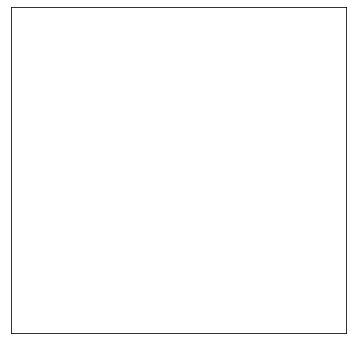

In [29]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name))

# plot vector data
print('Plotting LPIS vector data of eopatch: {}'.format(eopatch_name))
fig, ax = plt.subplots(figsize=(6, 6))
#LPIS = eopatch.vector_timeless['LPIS_{}'.format(year)]
#LPIS.plot(column='SNAR_BEZEI', ax=ax, categorical=True)
ax.set_aspect('auto')
ax.set_xticks(ticks=[])
ax.set_yticks(ticks=[])

del eopatch

As you can see, the crop types in your AOI are very diverse. Each colour stands for one of the over 200 LPIS classes.

# 3. Add EO data

## Choose EO features
Now, it's time to add Sentinel-2 data to the EOPatches. You are lucky to be using `eo-learn`, as this is simply done by setting up another single EOWorkflow including only a single EOTask for adding your satellite images. The remaining tasks allow you to create extensive valid data masks and useful indices using a ridiculously small amount of code.

In detail you add:
* L2A bands [B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12]
* Sen2cor's scene classification map and snow probability map
* SentinelHub's cloud probability map and cloud mask
* A mask of validity, based on acquired data from Sentinel and cloud coverage.

    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)
    

* Filter out time frames with < 70 % valid coverage (no clouds)
* Calculate and add NDVI, NDWI, NORM for helping the algorithm to detect relationships between the spectral bands.
* Prepare following Workflow by adding two features

### Set up  your 2. EOWorkflow - EO data

In [30]:
# TASK TO LOAD EXISTING EOPATCH
load = LoadTask(patch_path)

# TASK TO ADD SENTINEL 2 LEVEL 2A DATA
# Here also a simple filter of cloudy scenes is done. A detailed cloud cover 
# detection is performed within the next steps

# Using SH we will download the following data:
# * L2A bands: B02, B03, B04, B05, B06, B07, B08, B8A, B11, and B12
# * sen2cor's scene classification: SCL
# * s2cloudless' cloud mask: CLM
band_names = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']
add_l2a = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'MY-S2-L2A-BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=maxcloud,
    time_difference=timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'SCL'),
                     (FeatureType.MASK, 'CLM')],
    config=config,
    max_threads=5
)

# create valid data masks
scl_valid_classes = [2, 4, 5, 6, 7]

# TASKs FOR ADDING L2A and L1C VALID DATA MASKS
# convert cloudmask to validmask
add_clm_valid =MapFeatureTask((FeatureType.MASK, 'CLM'),
                             (FeatureType.MASK, 'CLM_VALID'),
                             np.logical_not)
# combine IS_DATA and CLM_VALID
add_l1c_valmask = ZipFeatureTask({FeatureType.MASK: ['IS_DATA', 'CLM_VALID']}, 
                            (FeatureType.MASK, 'L1C_VALID'),
                            np.logical_and)
# combine IS_DATA and SCL (using an erosion radius of 6 and a dilation radius of 22 pixel for SCL classes)
add_l2a_valmask = AddValidDataMaskTask(Sen2CorValidData(scl_valid_classes, 6, 22), 'L2A_VALID')
# combine all validmasks
add_valmask = ZipFeatureTask({FeatureType.MASK: ['L1C_VALID', 'L2A_VALID']}, 
                            (FeatureType.MASK, 'VALID_DATA'),
                            np.logical_and)

# TASK TO FILTER OUT SCENES INCLUDING TOO MANY UNVALID PIXEL
# keep frames with > x % valid coverage
valid_data_predicate = ValidDataFractionPredicate(datafrac)
filter_task = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'), valid_data_predicate)

# TASK FOR CALCULATING INDICES
# NDVI = Normalized Difference Vegetation Index
# NDWI = Normalized Difference Water Index
# NORM = Euclidean Norm
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'MY-S2-L2A-BANDS'), 
                                     (FeatureType.DATA, 'NDVI'),
                                     [6, 2])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'MY-S2-L2A-BANDS'), 
                                     (FeatureType.DATA, 'NDWI'),
                                     [1, 6])
norm = EuclideanNormTask((FeatureType.DATA, 'MY-S2-L2A-BANDS'), (FeatureType.DATA, 'NORM'))

# TASK FOR SAVING TO OUTPUT
save = SaveTask(patch_path, compress_level=1, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(load, 
                          add_l2a, 
                          add_clm_valid, 
                          add_l1c_valmask, 
                          add_l2a_valmask, 
                          add_valmask, 
                          filter_task, 
                          ndvi, 
                          ndwi, 
                          norm, 
                          save)

## Clean EOPatch list
Most likely, along with this innovative workflow, you are pushing humankind forward with other processes on your machine. Therefore you do not want to waste your ressources on EOPatches containing very little agricultural area. Before running your already set up EOWorkflow, clean your EOPatch list.

Remember the earlier calculated LPIS ratio? From here on you only keep EOPatches containing more than 13% agricultural area. The irrelevant ones are moved to the sidetrack. If you want to use EOPatches more extensively covered with agricultural area simply increase your "lpis_thres" configuration.

In [31]:
# # in GeoDataFrame label patches with certain thresold either as to do (1) or not to do (0)
# gdf[f'far{year}'] = -2.0
# for idx, row in gdf.iterrows():
#     patch_name = os.path.join(patch_path, f'eopatch_{idx}_col-{row.index_x}_row-{row.index_y}')
#     eop = EOPatch.load(str(patch_name), lazy_loading=True)
#     #gdf.loc[idx, f'far{year}'] = eop.scalar_timeless['FIELD_AREA_RATIO'][0]
    
# gdf[f'todo{year}'] = (gdf[f'far{year}'] > lpis_thres) * 1
# gdf.to_file(shapefile_name)

# # move EOPatch folders with LPIS coverage beneath thresold into seperate folder
# move = []
# patch_list_delete = gpd.read_file(shapefile_name)
# patch_list_delete = patch_list_delete[patch_list_delete[f'todo{year}'] == 0] # identify EOPatches with insufficient LPIS thresold

# # create list including names of the identified EOPatches
# for idx in patch_list_delete.index:
#     info = bbox_splitter.info_list[idx]
#     patch_name = f'eopatch_{idx}_col-{info["index_x"]}_row-{info["index_y"]}'
#     move.append(patch_name)
    
# print('EOPatches moved to sidetrack: ' + str([patch_name for patch_name in move]))

# # move identified EOPatches to alternative folder
# #for patch_name in move:
# #    shutil.move(os.path.join(patch_path, patch_name), os.path.join(thresLPIS_path, patch_name))

# patch_list = get_patch_list(patch_path) # update patch_list

In [32]:
#year = 2019
#time_interval = [f'{year}-01-01', f'{year}-04-30'] # the start and end date for downloading satellite data

### Run second EOWorkflow
* Set up EOWorkflow? **Check!**
* Ignored irrelevant EOPatches? **Check!**

Then go ahead and run your EOWorkflow on the basis of your "time_interval" configuration!

In [33]:
# only work with one patch for now
patch_list = ['eopatch_0_col-0_row-0']
patch_list 

['eopatch_0_col-0_row-0']

In [34]:
time_interval

['2018-10-01', '2019-07-30']

In [36]:
# execute workflow and save the names of those that failed
failed = []

for patch_name in tqdm(patch_list):
    # add EO data if possible
    try:
        workflow.execute({load: {'eopatch_folder': patch_name},
                          add_l2a: {'time_interval': time_interval},
                          #add_sc_feature: {'data': {}},
                          #add_rl_feature: {'data': {}},
                          save: {'eopatch_folder': patch_name}})
    # append EOPatch name to list for further investigation
    except Exception as ex:
        print(f'Failed {patch_name} with {ex}')
        failed.append(patch_name)


  0%|          | 0/1 [00:00<?, ?it/s]

# 4. Feature/ label engineering and Sampling
The classifier you are using for the following prediction is very picky when it comes to the format of the input data. To feed your thoughtfully compiled data to the algorithm it needs some preparation.

## Data visualization

Now, after all necessary data is added let's load a single EOPatch and look at the structure. By executing 
```
EOPatch.load(os.path.join(patch_path, 'eopatch_0_col-0_row-0'))
```

You obtain the following structure:

```
EOPatch(
  data: {
    MY-S2-L2A-BANDS: numpy.ndarray(shape=(39, 1028, 1033, 10), dtype=float32)
    NDVI: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
    CLM_VALID: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(39, 1028, 1033, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2018: geopandas.GeoDataFrame(columns=['geometry', 'FS_KENNUNG', 'SL_FLAECHE', 'ID', 'SNAR_BEZEI', 'DateImported'], length=4091, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ['2018-01-01', '2018-09-30']
  }
  bbox: BBox(((420862.3179607267, 5329537.336315366), (431194.28800678457, 5339817.792378783)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 1, 6, 10, 4, 51), ..., datetime.datetime(2018, 9, 28, 10, 0, 24)], length=39
)
```

As you can see your EO data and indices are stored in `data.FeatureType` your valid data masks in `mask.FeatureType` and your ground truth data in `vector_timeless.FeatureType`


It is possible to access various EOPatch content via calls like:
```
eopatch.timestamp
eopatch.vector_timeless['LPIS_2018']
eopatch.data['NDVI'][0]
eopatch.data['MY-S2-L2A-BANDS'][5][..., [3, 2, 1]]

```

In [59]:
# eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
# eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)
# eopatch.data['MY-S2-L2A-BANDS'][:,:,1,:]

### Plot RGB image
In order to get a quick and realistic overview of your AOI you plot the true color image of one EOPatch

These figures are from  eopatch_0_col-0_row-0 on  2018-10-12 10:30:19+00:00


Text(0.5, 1.0, 'Band 9')

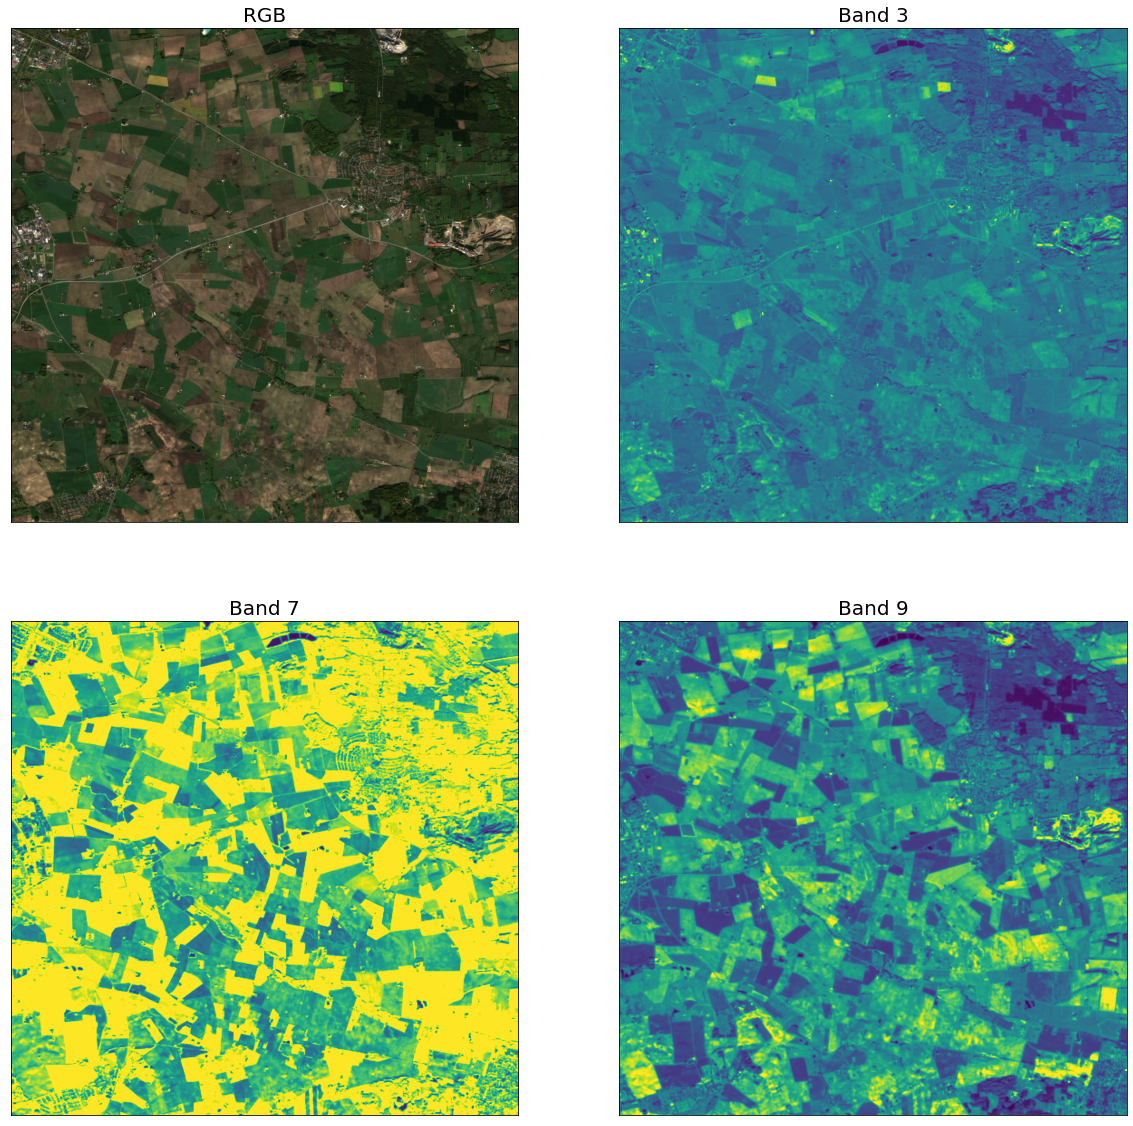

In [37]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)

tm = 0
time_chosen = eopatch.timestamp[tm]
print("These figures are from ",eopatch_name, "on ", time_chosen)
fig, ax = plt.subplots(figsize=(20,20))

ax = plt.subplot(2, 2, 1)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [2, 1, 0]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('RGB', fontsize=20)


ax = plt.subplot(2, 2, 2)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [3]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 3', fontsize=20)

ax = plt.subplot(2, 2, 3)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [7]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 7', fontsize=20)

ax = plt.subplot(2, 2, 4)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tm][..., [9]] * 3.5, 0, 1))
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Band 9', fontsize=20)


In [53]:
eopatch.timestamp#.meta_info["time_interval"]

[datetime.datetime(2018, 10, 12, 10, 30, 19, tzinfo=tzlocal()),
 datetime.datetime(2018, 10, 14, 10, 20, 19, tzinfo=tzlocal()),
 datetime.datetime(2018, 10, 17, 10, 32, 2, tzinfo=tzlocal()),
 datetime.datetime(2018, 10, 24, 10, 24, 28, tzinfo=tzlocal()),
 datetime.datetime(2018, 11, 3, 10, 23, 38, tzinfo=tzlocal()),
 datetime.datetime(2018, 11, 16, 10, 35, 21, tzinfo=tzlocal()),
 datetime.datetime(2018, 11, 26, 10, 35, 20, tzinfo=tzlocal()),
 datetime.datetime(2019, 1, 5, 10, 35, 22, tzinfo=tzlocal()),
 datetime.datetime(2019, 2, 16, 10, 25, 24, tzinfo=tzlocal()),
 datetime.datetime(2019, 2, 24, 10, 45, 53, tzinfo=tzlocal()),
 datetime.datetime(2019, 3, 1, 10, 47, 33, tzinfo=tzlocal()),
 datetime.datetime(2019, 3, 31, 10, 49, 13, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 2, 10, 34, 30, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 5, 10, 36, 11, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 20, 10, 46, 12, tzinfo=tzlocal()),
 datetime.datetime(2019, 4, 22, 10, 32, 13, tzinfo=tzl

### Plot mean NDVI
Plot the time-wise mean of NDVI for the whole region. Filter out clouds in the mean calculation.

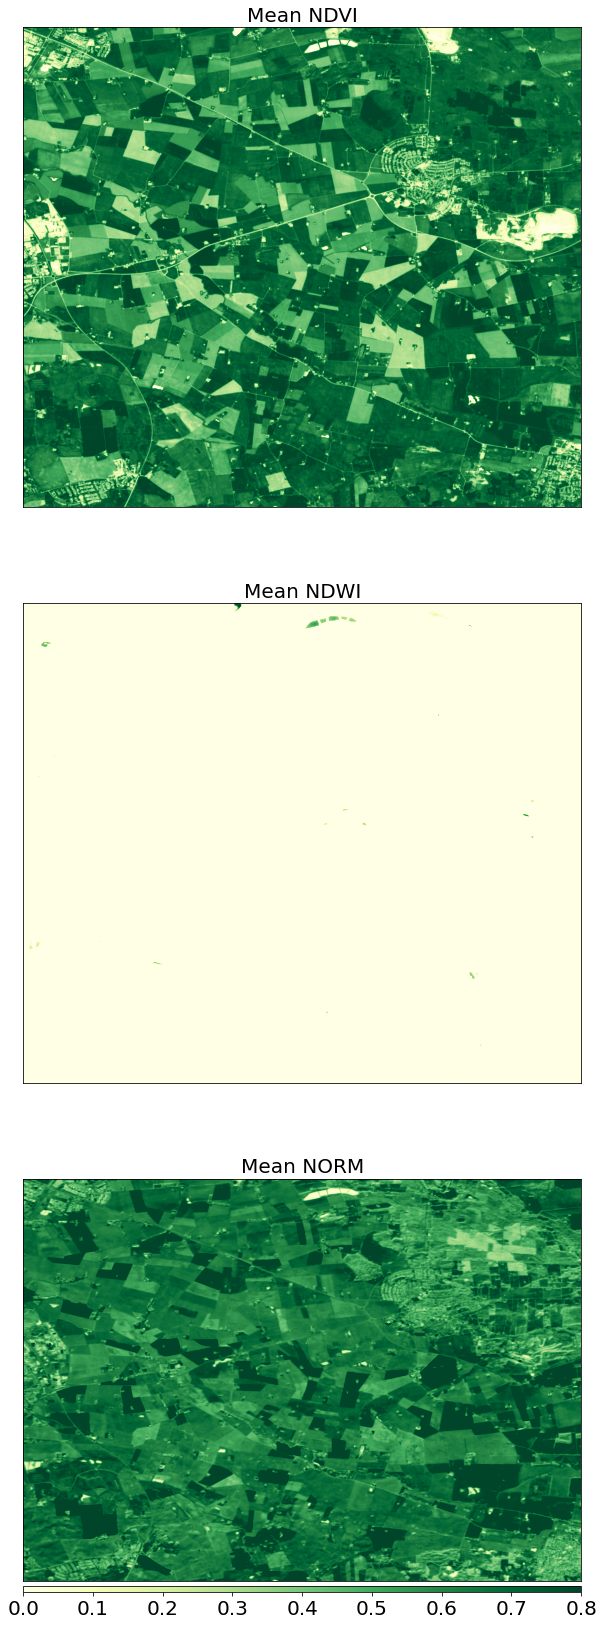

In [54]:
fig, ax = plt.subplots(figsize=(10,30))

ax = plt.subplot(3, 1, 1)
ndvi = eopatch.data['NDVI']
#mask = eopatch.mask['VALID_DATA']
#ndvi[~mask] = np.nan
ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')
plt.title('Mean NDVI', fontsize=20)

ax = plt.subplot(3, 1, 2)
ndwi = eopatch.data['NDWI']
#mask = eopatch.mask['VALID_DATA']
#ndvi[~mask] = np.nan
ndwi_mean = np.nanmean(ndwi, axis=0).squeeze()
im = ax.imshow(ndwi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')
plt.title('Mean NDWI', fontsize=20)

ax = plt.subplot(3, 1, 3)
norm = eopatch.data['NORM']
#mask = eopatch.mask['VALID_DATA']
#ndvi[~mask] = np.nan
norm_mean = np.nanmean(norm, axis=0).squeeze()
im = ax.imshow(norm_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')
plt.title('Mean NORM', fontsize=20)

cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

### Plot all masks
To see how the valid data masks look like and work together, you can compare them to a regular RGB image. For demonstration reasons a timeframe is selected which contains cloud-covered area.

These figures are from  eopatch_0_col-0_row-0 on: 2019-04-25 10:45:52+00:00


Text(0.5, 1.0, 'VALID_DATA - Combined valid data mask')

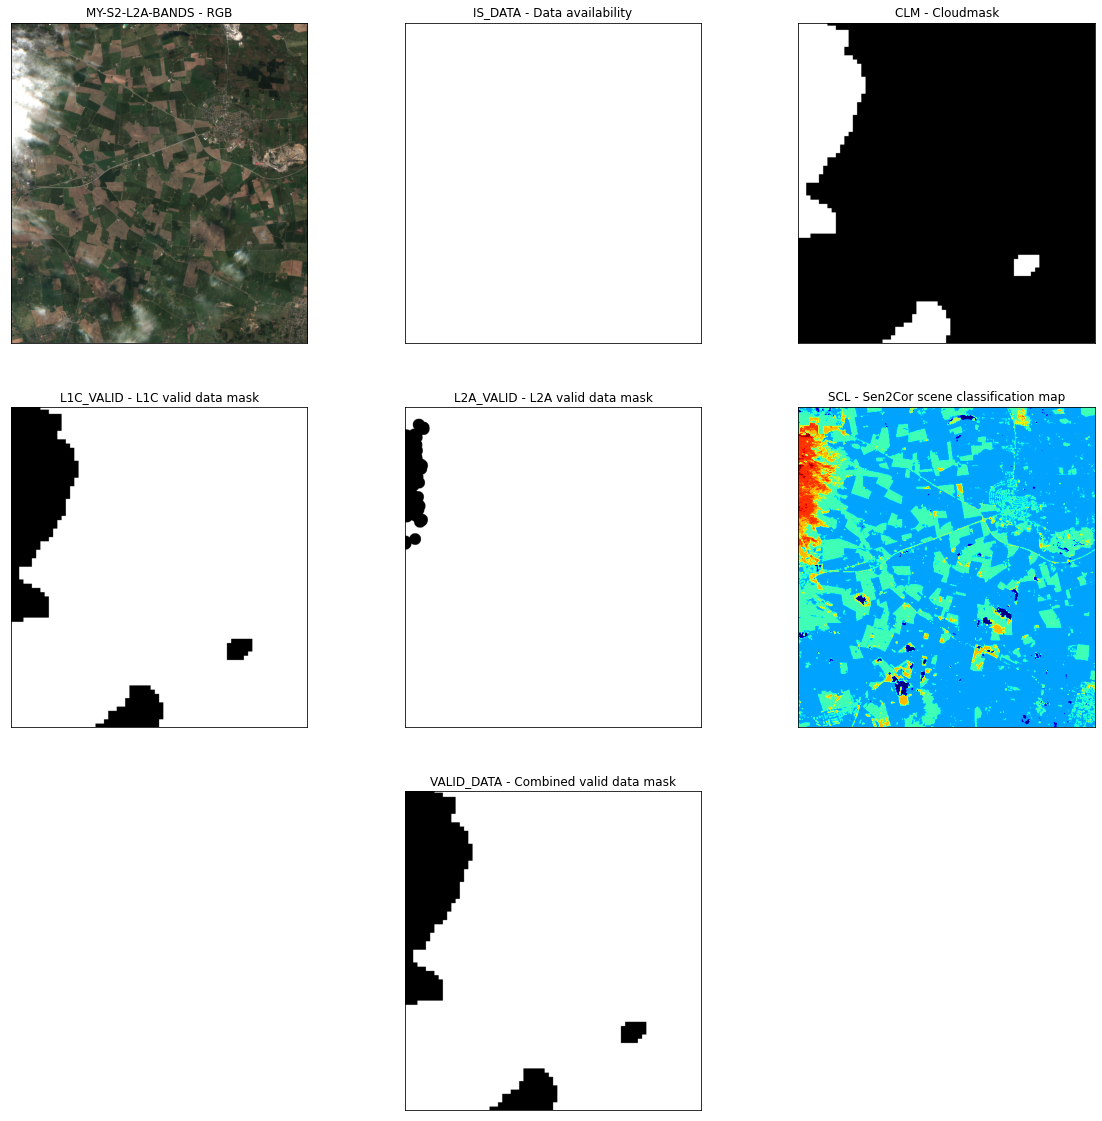

In [55]:
tidx = 16
time_chosen = eopatch.timestamp[tidx]
print("These figures are from ",eopatch_name, "on:", time_chosen)

plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(np.clip(eopatch.data['MY-S2-L2A-BANDS'][tidx][..., [2,1,0]] * 3.5,0,1))
plt.xticks([])
plt.yticks([])
plt.title('MY-S2-L2A-BANDS - RGB')

plt.subplot(332)
plt.imshow(eopatch.mask['IS_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('IS_DATA - Data availability')

plt.subplot(333)
plt.imshow(eopatch.mask['CLM'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('CLM - Cloudmask')

plt.subplot(334)
plt.imshow(eopatch.mask['L1C_VALID'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('L1C_VALID - L1C valid data mask')

plt.subplot(335)
plt.imshow(eopatch.mask['L2A_VALID'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('L2A_VALID - L2A valid data mask')

plt.subplot(336)
plt.imshow(eopatch.mask['SCL'][tidx].squeeze(), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title('SCL - Sen2Cor scene classification map')

plt.subplot(338)
plt.imshow(eopatch.mask['VALID_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('VALID_DATA - Combined valid data mask')

As you can see invalid pixel from the different cloud masks and Sen2Cor scene classification map are combined. For SCL the classes: 
* 1 SC_SATURATED_DEFECTIVE 
* 3 SC_CLOUD_SHADOW 
* 8 SC_CLOUD_MEDIUM_PROBABILITY 
* 9 CLOUD_HIGH_PROBABILITY 
* 10 THIN_CIRRUS 
* 11 SNOW 

are considered as invalid.

### Plot spatial mean NDVI timeseries
Plot the mean of NDVI over all pixels in a single patch throughout the year. Filter out clouds in the mean calculation.

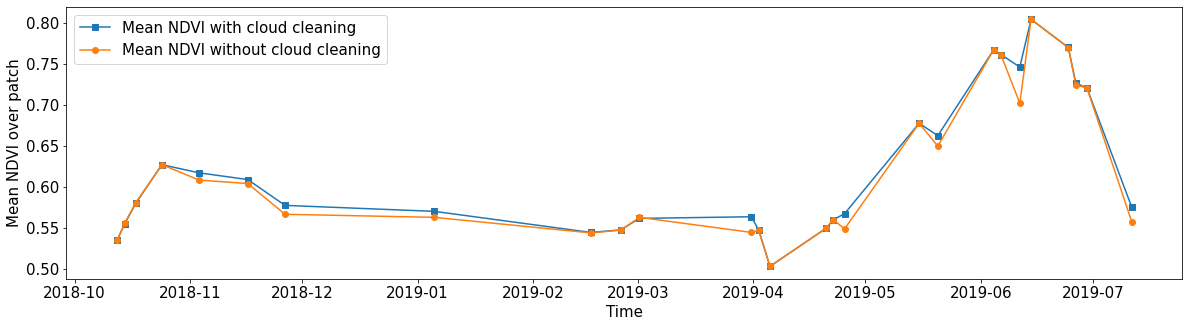

In [56]:
ndvi_series = eopatch.data['NDVI']
time = np.array(eopatch.timestamp)
mask = eopatch.mask['VALID_DATA']
t, w, h, _ = ndvi_series.shape

ndvi_clean = ndvi_series.copy()
ndvi_clean[~mask] = np.nan # set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi_series.reshape(t, w * h).squeeze(), axis=1)
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h).squeeze(), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(time_clean, ndvi_mean_clean, 's-', label = 'Mean NDVI with cloud cleaning')
plt.plot(time, ndvi_mean, 'o-', label='Mean NDVI without cloud cleaning')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI over patch', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=2, prop={'size': 15});
ax.set_aspect('auto')

del eopatch # delete eopatch variable to enable further processing

The time series displayed looks very fragmented for the temporal resolution of the Sentinel 2 data to be so hyped, right?

This is what you get if you choose to keep timeframes with valid data fraction over 70% only. You set the value in your "datafrac" configuration. If you expect a nice overview of vegetation growing stages, reality kicks in and gives you mostly cloudy conditions in the first months of the year.
The good thing about being picky about the validity of your timeframes is reduced data volume. Invalid frames contain no additional value for your later analysis anyways.

## Resampling - Interpolation - LPIS data preparation - Sampling
### Feature concatenation and interpolation
* For easier handling of the data you concatenate MY-S2-L2A-BANDS, NDVI, NDWI, NORM info into a single feature called FEATURES
* Perform temporal interpolation (filling gaps and resampling to the same dates) by:
    * creating a linear interpolation task in the temporal dimension
    * providing the cloud mask to tell the interpolating function which values to update
    * using only timeframes from a timerange all EOPatches have in common (from earliest date to latest date)

### LPIS data preparation
* From scratch, LPIS data is divided into 200 different crop type classes. As the classification is based on spectral signatures, those have to be distinctive. 200 classes are obviously too detailed for achieving accurate prediction results. Therefore you group these classes into reasonable groups also based on similar spectral characteristics using the two CSV files from the "General data" folder. The basic grouping defines 14 groups namely: Grass, Maize, Orchards, Peas, Potatoes, Pumpkins, Soybean, Summer cereals, Sunflower, Vegetables, Vine-yards, Winter cereals, Winter rape, Other. This grouping turned out to perform best in classification.
* After the grouping, the data set stored in vector format is converted into a raster format. Thus, each EO pixel can be assigned to a crop type value. All polygons belonging to one of the classes are separately burned to the raster mask.
* In order to get rid of artifacts with a width of 1 pixel, and mixed pixels at the edges between polygons of different classes you perform an erosion. That means a buffer of 1 pixel (10m) size is applied to each individual field in the border area.

### Sampling
By a spatial sampling of the EOPatches you randomly take a subset of pixels from a patch to use in the machine learning training and testing. Here you only want to consider classes that are represented to a certain quantity of pixels.
* Remember your "pixel_tres" configuration - a threshold of 1000 pixel is necessary for a class to be considered in sampling
* Remember your "samp_class" configuration - 500 pixel per class per EOPatch are sampled

In [57]:
# for linear interpolation find earliest and latest overlapping dates

# list EOPatches
eopatches = []

patch_list = get_patch_list(patch_path)

cnt = 0
for i in patch_list:
    temp = EOPatch.load(os.path.join(patch_path, i), lazy_loading=True)
    if temp.timestamp==[]:
        print("Throwing away (since empty) frame with timestamp:",i)
        cnt+=1
    else:
        eopatches.append(temp)
print("Thrown out:", cnt)

eopatches = np.array(eopatches)

# identify  earliest date
timelist = []
for eopatch in eopatches:
    #print("cnt=",cnt)
    #print(eopatch)
    #print(eopatch.timestamp)
    timelist.append(eopatch.timestamp[0])
mindate = str(max(timelist).date())
print('Earliest date: ' + str(max(timelist)))

# identify  latest date
timelist = []
for eopatch in eopatches:
    timelist.append(eopatch.timestamp[-1])
maxdate = str(min(timelist).date())
print('Latest date: ' + str(min(timelist)))

Throwing away (since empty) frame with timestamp: eopatch_1_col-1_row-0
Throwing away (since empty) frame with timestamp: eopatch_2_col-2_row-0
Thrown out: 2
Earliest date: 2018-10-12 10:30:19+00:00
Latest date: 2019-07-11 10:25:36+00:00


In [58]:
len(eopatches)

1

In [59]:
temp

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((410588.5333333333, 6161829.1), (421796.0, 6173904.3)), crs=CRS('32633'))
  timestamp: []
)

### Set up your 3. EOWorkflow - Feature engineering/ Crop type grouping/ Sampling

In [148]:
#eopatches[0].vector_timeless['LPIS_2019'].head()
patch_list = ['eopatch_0_col-0_row-0']

In [162]:
# TASK FOR LOADING EXISTING EOPATCHES
load = LoadTask(patch_path)

# TASK FOR CONCATENATION
# bands and indices are concatenated into one features dictionary
concatenate = ConcatenateData('FEATURES', 
                              ['MY-S2-L2A-BANDS',
                               'NDVI',
                               'NDWI',
                               'NORM'])

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resample_range = (mindate, maxdate, day_range)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'VALID_DATA'), # mask to be used in interpolation
    #copy_features=[(FeatureType.VECTOR_TIMELESS, 'LPIS_{}'.format(year))], # features to keep
    resample_range=resample_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK TO FIX AUSTRIAN LPIS DATA
# on the basis of the wrongly defined column "SNAR_BEZEI" 
# a column "SNAR_BEZEI_NAME" is added which defines the LPIS class
fixlpis = FixLPIS(feature='LPIS_{}'.format(year), country='Sweden')#'Austria')

# TASK FOR GROUPING LPIS INTO WANTED CLASSES
# on the basis of the two grouping files an individual crop type grouping can be applied
# for changes these files have to be adapted
grouplpis = GroupLPIS(year=year, lpis_to_group_file=lpis_to_group_file, crop_group_file=crop_group_file)

# TASK FOR CONVERTING LPIS DATA FROM VECTOR TO RASTER FORMAT
# multiple rasterized layers appling different crop type groupings can be stored in an EOPatch
vtr = VectorToRaster(
    vector_input=(FeatureType.VECTOR_TIMELESS, 'LPIS_{}'.format(year)), 
    raster_feature=(FeatureType.MASK_TIMELESS, 'LPIS_class_{}'.format(grouping_id)),
    values_column='GROUP_1_ID',
    raster_shape=(FeatureType.DATA, 'FEATURES'),
    no_data_value=0)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LPIS_class_{}'.format(grouping_id),
                                    'LPIS_class_{}_ERODED'.format(grouping_id)), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# evenly sample about pixels from patches
spatial_sampling = SamplingTaskTask(grouping_id, pixel_thres, samp_class)

#remove = GroupLPIS(raster_shape=(FeatureType.DATA,'FEATURES'), resample_range=ts,)
# NEW TASK
#removing = removeTask(raster_shape=(FeatureType.DATA,'FEATURES'), 
#                      vector_input=(FeatureType.timestamp))
# # create a list of true (1) and false (0) values based on timestamp
# mask_time = [False if eopatch.timestamp[l].month in [11, 12, 1, 2] else True for l in range(len(eopatch.timestamp))]

# # First remore a number of rows from FEATURES
# temp_patch = eopatch.data['FEATURES']
# t, u, v, h = temp_patch.shape
# new_temp = temp_patch.reshape(t, u*v*h)
# new_temp = new_temp[mask_time,:]

# new_temp = new_temp.reshape(new_temp.shape[0],u,v,h)
# eopatch.data['FEATURES'] = new_temp

# Now also adjust the respective timestamp
#temp_stamp = eopatch.timestamp
#temp_stamp = list(itertools.compress(temp_stamp, mask_time))
#eopatch.timestamp = temp_stamp


# TASK FOR SAVING TO OUTPUT
save = SaveTask(patch_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# define the workflow
workflow = LinearWorkflow(load, 
                          concatenate, 
                          linear_interp, 
                          #fixlpis, 
                          #grouplpis, 
                          #vtr, 
                          #erosion, 
                          #spatial_sampling,
                          save)

### Run third EOWorkflow

In [202]:

for patch_name in tqdm(patch_list):
    extra_param = {load: {'eopatch_folder': patch_name},
                   #grouplpis: {'col_cropN_lpis': 'SNAR_BEZEI_NAME',
                   #           'col_cropN_lpistogroup': 'CROP_ID'},
                   save: {'eopatch_folder': patch_name}}

    workflow.execute(extra_param)

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: During execution of task SaveTask: execute() missing 1 required positional argument: 'eopatch'

In [163]:
#eopatch = EOPatch.load(os.path.join(patch_path, 'eopatch_0_col-0_row-0'))
eopatch#.timestamp[0].month

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(19, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=19
)

In [108]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)
#eopatch.data['FEATURES'].shape #[:,:,1,:]
#eopatch.timestamp

[datetime.datetime(2018, 10, 12, 0, 0),
 datetime.datetime(2018, 10, 20, 0, 0),
 datetime.datetime(2018, 10, 28, 0, 0),
 datetime.datetime(2018, 11, 5, 0, 0),
 datetime.datetime(2018, 11, 13, 0, 0),
 datetime.datetime(2018, 11, 21, 0, 0),
 datetime.datetime(2018, 11, 29, 0, 0),
 datetime.datetime(2018, 12, 7, 0, 0),
 datetime.datetime(2018, 12, 15, 0, 0),
 datetime.datetime(2018, 12, 23, 0, 0),
 datetime.datetime(2018, 12, 31, 0, 0),
 datetime.datetime(2019, 1, 8, 0, 0),
 datetime.datetime(2019, 1, 16, 0, 0),
 datetime.datetime(2019, 1, 24, 0, 0),
 datetime.datetime(2019, 2, 1, 0, 0),
 datetime.datetime(2019, 2, 9, 0, 0),
 datetime.datetime(2019, 2, 17, 0, 0),
 datetime.datetime(2019, 2, 25, 0, 0),
 datetime.datetime(2019, 3, 5, 0, 0),
 datetime.datetime(2019, 3, 13, 0, 0),
 datetime.datetime(2019, 3, 21, 0, 0),
 datetime.datetime(2019, 3, 29, 0, 0),
 datetime.datetime(2019, 4, 6, 0, 0),
 datetime.datetime(2019, 4, 14, 0, 0),
 datetime.datetime(2019, 4, 22, 0, 0),
 datetime.datetime(20

In [96]:
eopatch#.timestamp
#mask_time

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(19, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=34
)

In [109]:
# create a list of true (1) and false (0) values based on timestamp
mask_time = [False if eopatch.timestamp[l].month in [11, 12, 1, 2] else True for l in range(len(eopatch.timestamp))]

# First remore a number of rows from FEATURES
temp_patch = eopatch.data['FEATURES']
t, u, v, h = temp_patch.shape
new_temp = temp_patch.reshape(t, u*v*h)
new_temp = new_temp[mask_time,:]

new_temp = new_temp.reshape(new_temp.shape[0],u,v,h)
eopatch.data['FEATURES'] = new_temp

# Now also adjust the respective timestamp
temp_stamp = eopatch.timestamp
temp_stamp = list(itertools.compress(temp_stamp, mask_time))
eopatch.timestamp = temp_stamp

In [165]:
filename = 'test'
eopatch.save(patch_path+'/'+filename+'.npy', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [211]:
# Test re-loading the eopatch 
patch2 = EOPatch.load(patch_path+'/'+filename+'.npy')

In [214]:
len(patch2.timestamp)

19

In [188]:
new_eopatch = np.load(patch_path+'/'+filename+'.npy',allow_pickle=True)

In [207]:
new_eopatch

array(EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(19, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=19
), dtype=object)

In [1]:
# save = SaveTask('io_example', overwrite_permission=2, compress_level=1)

# workflow = LinearWorkflow(save)

# result = workflow.execute(save: {'eopatch_folder': patch_path}) #{input_task: {‘bbox’: roi_bbox, ‘time_interval’: time_interval},


In [199]:
# And in this last workflow we just save the patch again

# define the workflow
workflow = LinearWorkflow(save)

for patch_name in tqdm(patch_list):
    extra_param = {load: {'eopatch_folder': patch_name},
                   #grouplpis: {'col_cropN_lpis': 'SNAR_BEZEI_NAME',
                   #           'col_cropN_lpistogroup': 'CROP_ID'},
                   save: {'eopatch_folder': patch_name}}

    workflow.execute(extra_param)

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: During execution of task SaveTask: execute() missing 1 required positional argument: 'eopatch'

### EOPatch data visualization

Now, after all the data is transformed and sampled let's load the single EOPatch again and look at the structure. By executing 
```
EOPatch.load(os.path.join(patch_path, 'eopatch_0_col-0_row-0')
```

You obtain the following structure:


```
EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(31, 1033, 1040, 13), dtype=float64)
    FEATURES_SAMPLED: numpy.ndarray(shape=(31, 6000, 1, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_class_basic: numpy.ndarray(shape=(1033, 1040, 1), dtype=uint8)
    LPIS_class_basic_ERODED: numpy.ndarray(shape=(1033, 1040, 1), dtype=uint8)
    LPIS_class_basic_ERODED_SAMPLED: numpy.ndarray(shape=(6000, 1, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    LPIS_2018: geopandas.GeoDataFrame(columns=['geometry', 'FS_KENNUNG', 'SL_FLAECHE', 'ID', 'SNAR_BEZEI', 'DateImported', 'SNAR_BEZEI_NAME', 'CROP_ID', 'english', 'slovenian', 'latin', 'GROUP_1', 'GROUP_1_original', 'GROUP_1_ID'], length=4140, crs=epsg:32633)
  }
  meta_info: {}
  bbox: BBox(((420717.14926283853, 5329441.919254168), (431121.7036578405, 5339770.083848184)), crs=EPSG:32633)
  timestamp: [datetime.datetime(2018, 1, 29, 0, 0), ..., datetime.datetime(2018, 9, 26, 0, 0)], length=31
)
```

Things have changed, haven't they?

Your 10 spectral bands and 3 indices are combined in `FEATURES` and the randomly sampled pixels are stored in `FEATURES_SAMPLED`. After filtering, your valid data masks have been deleted and your eroded and sampled reference data is available in practical raster format as `mask_timeless.FeatureType`.

## Combine samples and split into train and test data
As you performed the spatial sampling for each patch separately you have to combine the samples. But first you have to assign your EOPatches either to the training or validation dataset. In this case you take one in four EOPatches for testing.

Only classes present in both train and test dataset are considered in the classification.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features, with $f$ the size of bands and band combinations (in this example 13) and $t$ the length of the resampled time-series (in this example 34)

Terminology: In data science features are commonly refered to as "X" and labels as "y"

In [327]:
# EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
# os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)

In [325]:
# patch_list = get_patch_list(patch_path) # update patch list
# len(patch_list)

10

In [105]:
# LOAD EXISTING EOPATCHES
load = LoadTask(patch_path)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ['BANDS', 'NDVI', 'NDWI', 'NDBI']},
                               (FeatureType.DATA, 'FEATURES'))
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

NameError: name 'EOPATCH_SAMPLES_FOLDER' is not defined

In [331]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    #filter_task,
    #linear_interp,
    #erosion,
    #spatial_sampling,
    save
)

In [106]:
EOPatch.load(os.path.join(patch_path, 'eopatch_0_col-0_row-0'))

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 1208, 1121, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((388173.6, 6161829.1), (399381.06666666665, 6173904.3)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 10, 12, 0, 0), ..., datetime.datetime(2019, 7, 3, 0, 0)], length=34
)

In [344]:
patch_path

'/notebooks/notebooks/AgricultureProject/eo-learn-master/examples/crop-type-classification/Output/EOPatches'

In [84]:
# This creates lists from eopatch data

# Load sampled eopatches
sampled_eopatches = []

for idx, bbox in enumerate(tqdm(bbox_list)):
    bbox = bbox_splitter.bbox_list[idx]
    info = bbox_splitter.info_list[idx]
    patch_name = f'eopatch_{idx}_col-{info["index_x"]}_row-{info["index_y"]}'
    sample_path = os.path.join(patch_path, patch_name)
    temp = EOPatch.load(sample_path, lazy_loading=True)
    #print(temp.data["FEATURES"][:,:,1,:])
    #sampled_eopatches[1].data["FEATURES"][:,:,1,:] #.shape
    sampled_eopatches.append(temp.data["FEATURES"][:,:,1,:])# 

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
sampled_eopatches

[EOPatch(
   data: {
     FEATURES: FeatureIO(/data/FEATURES.npy)
     MY-S2-L2A-BANDS: FeatureIO(/data/MY-S2-L2A-BANDS.npy)
     NDVI: FeatureIO(/data/NDVI.npy)
     NDWI: FeatureIO(/data/NDWI.npy)
     NORM: FeatureIO(/data/NORM.npy)
   }
   mask: {
     CLM: FeatureIO(/mask/CLM.npy)
     IS_DATA: FeatureIO(/mask/IS_DATA.npy)
     SCL: FeatureIO(/mask/SCL.npy)
   }
   scalar: {}
   label: {}
   vector: {}
   data_timeless: {}
   mask_timeless: {}
   scalar_timeless: {}
   label_timeless: {}
   vector_timeless: {}
   meta_info: {
     maxcc: 0.8
     size_x: 1387
     size_y: 1048
     time_difference: datetime.timedelta(seconds=7200)
     time_interval: (datetime.datetime(2019, 5, 1, 0, 0), datetime.datetime(2019, 7, 30, 23, 59, 59))
   }
   bbox: BBox(((497560.526270664, 6501840.98543143), (511433.9383348584, 6512318.825626513)), crs=CRS('32633'))
   timestamp: [datetime.datetime(2019, 5, 2, 10, 24, 29, tzinfo=tzlocal()), ...], length=23
 ),
 EOPatch(
   data: {
     FEATURES: Featu

In [80]:
sampled_eopatches[1].data["FEATURES"][:,:,1,:]#.shape

array([[[ 0.0365    ,  0.0404    ,  0.0503    , ...,  0.14745763,
         -0.25254396,  0.2839293 ],
        [ 0.042     ,  0.0478    ,  0.0626    , ...,  0.14480875,
         -0.27355623,  0.29245186],
        [ 0.0441    ,  0.0526    ,  0.0685    , ...,  0.16259171,
         -0.28774545,  0.3450907 ],
        ...,
        [ 0.0272    ,  0.0174    ,  0.0128    , ..., -0.05785122,
          0.20833334,  0.04318924],
        [ 0.0242    ,  0.0174    ,  0.0116    , ..., -0.01754387,
          0.21678324,  0.04034204],
        [ 0.0272    ,  0.0188    ,  0.0115    , ..., -0.01321588,
          0.25333333,  0.04277908]],

       [[ 0.5936    ,  0.5456    ,  0.5468    , ...,  0.07572681,
         -0.07681894,  1.742124  ],
        [ 0.5596    ,  0.5248    ,  0.54      , ...,  0.06380028,
         -0.07800423,  1.7139523 ],
        [ 0.5428    ,  0.5184    ,  0.5264    , ...,  0.06200996,
         -0.06963389,  1.7000699 ],
        ...,
        [ 0.6744    ,  0.5912    ,  0.5812    , ...,  

In [76]:
patch_list

['eopatch_1_col-1_row-0', 'eopatch_0_col-0_row-0', 'eopatch_2_col-2_row-0']

In [87]:
patchIDs = patch_list
# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 2, 3, 5, 6, 9]
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]


In [93]:
train_eopatches[2].shape

(22, 1048, 13)

In [86]:
patchIDs = patch_list

# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 2, 3, 5, 6, 9]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]

# Grouping eopatches into test and train
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in train_eopatches])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in train_eopatches])

features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in test_eopatches])
labels_test = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in test_eopatches])

# Get shape
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1 + p2

# Reshape to n x m
features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * h, t * f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(p1 * w * h)
features_test = np.moveaxis(features_test, 1, 3).reshape(p2 * w * h, t * f)
labels_test = np.moveaxis(labels_test, 1, 2).reshape(p2 * w * h)

# Remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]

# Remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask_test = labels_test == 0
features_test = features_test[~mask_test]
labels_test = labels_test[~mask_test]

TypeError: memoryview: invalid slice key

In [342]:
%%time
patch_list = get_patch_list(patch_path) # update patch list   
execution_args = []

for idx, bbox in enumerate(tqdm(bbox_list)):
    bbox = bbox_splitter.bbox_list[idx]
    info = bbox_splitter.info_list[idx]
    patch_name = f'eopatch_{idx}_col-{info["index_x"]}_row-{info["index_y"]}'
#    workflow.execute({create:{'bbox':bbox}, save:{'eopatch_folder':patch_name}})

    execution_args.append({
        load: {patch_name},
        #spatial_sampling: {'seed': 42},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=True)

#executor.make_report()

#failed_ids = executor.get_failed_executions()
#if failed_ids:
#    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
#                       f'For more info check report at {executor.get_report_filename()}')

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Execution input arguments of each task should be a dictionary or a tuple, for task LoadTask got arguments of type <class 'set'>

In [349]:
for idx in patch_list.index:
    print(idx)

TypeError: 'builtin_function_or_method' object is not iterable

In [323]:
# combine EOPatches to one dataset
patch_list = get_patch_list(patch_path) # update patch list

eopatches = []
for i in patch_list:
    temp = EOPatch.load(os.path.join(patch_path, i), lazy_loading=True)
    if temp.data == {}:
        print("Empy patch! Erasing")
    else:
        eopatches.append(temp)

eopatches = np.array(eopatches)
eopatches

array([EOPatch(
  data: {
    FEATURES: FeatureIO(/data/FEATURES.npy)
    MY-S2-L2A-BANDS: FeatureIO(/data/MY-S2-L2A-BANDS.npy)
    NDVI: FeatureIO(/data/NDVI.npy)
    NDWI: FeatureIO(/data/NDWI.npy)
    NORM: FeatureIO(/data/NORM.npy)
  }
  mask: {
    CLM: FeatureIO(/mask/CLM.npy)
    CLM_VALID: FeatureIO(/mask/CLM_VALID.npy)
    IS_DATA: FeatureIO(/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/mask/L2A_VALID.npy)
    SCL: FeatureIO(/mask/SCL.npy)
    VALID_DATA: FeatureIO(/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    size_x: 1387
    size_y: 1048
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2019, 5, 1, 0, 0), datetime.datetime(2019, 7, 30, 23, 59, 59))
  }
  bbox: BB

In [45]:
patch_list = get_patch_list(patch_path) # update patch list

# combine EOPatches to one dataset
#eopatches = []
#for i in patch_list:
#    eopatches.append(EOPatch.load(os.path.join(patch_path, i), lazy_loading=True))

#eopatches = np.array(eopatches)

# depending on the number of EOPatches adjust test_ratio if necessary and split into test and train data accordingly
if len(patch_list) == 1:
    # split combined dataset into train and test data
    X_train, X_test, y_train, y_test, n_timesteps, n_features = train_test_split_eopatch(eopatches, 
                                                                features_dict, 
                                                                labels_dict)

elif len(patch_list) < 4:
    test_ratio = 3
    # split combined dataset into train and test data
    X_train, X_test, y_train, y_test, n_timesteps, n_features = train_test_split_eopatches(eopatches, 
                                                                  test_ratio, 
                                                                  features_dict, 
                                                                  labels_dict)

else:
    # split combined dataset into train and test data
    X_train, X_test, y_train, y_test, n_timesteps, n_features = train_test_split_eopatches(eopatches, 
                                                                  test_ratio, 
                                                                  features_dict, 
                                                                  labels_dict)

# mask out labels that are not in both train and test data and also mask out samples where features include NaN values
X_train, X_test, y_train, y_test = masking(X_train, X_test, y_train, y_test)

#total_samp_count = X_train.shape[0] + X_test.shape[0]
print('From your {} EOPatch(es) at total of {} samples were taken. '
     'This sampling dataset includes {} training and {} test samples.'.format(len(patch_list), 
                                                                              total_samp_count, 
                                                                              X_train.shape[0], 
                                                                              X_test.shape[0]))

ResourceNotFound: resource '/data/NORM.npy.gz' not found

### Plot sample distribution

In [100]:
fig = plt.figure(figsize=(20, 15))

y_ids_train, y_counts_train = np.unique(y_train, return_counts=True)

plt.subplot(2, 1, 1)
plt.bar(range(len(y_ids_train)), y_counts_train)
plt.xticks(range(len(y_ids_train)), [class_names[i] for i in y_ids_train], rotation=90, fontsize=20);
plt.yticks(fontsize=20)
plt.grid(True)
plt.title('Training samples', size=20)

y_ids_test, y_counts_test = np.unique(y_test, return_counts=True)

plt.subplot(2, 1, 2)
plt.bar(range(len(y_ids_test)), y_counts_test)
plt.xticks(range(len(y_ids_test)), [class_names[i] for i in y_ids_test], rotation=90, fontsize=20);
plt.yticks(fontsize=20)
plt.grid(True)
plt.title('Test samples', size=20)

fig.subplots_adjust(wspace=0, hspace=1)

NameError: name 'y_train' is not defined

<Figure size 1440x1080 with 0 Axes>

As you can see you have managed to generate a well balanced dataset. In both your 3/4 training and 1/4 test dataset no group is under or over represented, which provides a reasonable basis for the following classification.

### Scaling and one-hot-encoding
In the following you want to feed your samples into two different algorithms. To guarantee equivalent conditions for both models you need scaled features and one-hot-endcoded labels.

In [51]:
# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.reshape(X_train, (-1,n_timesteps,n_features))
X_test = np.reshape(X_test, (-1,n_timesteps,n_features))
# save feature related scaling properties
joblib.dump(scaler, os.path.join(samples_path, 
                                 'Scaler_{}.bin'.format(grouping_id)), 
                                 compress=True)

# labels one- hot-encoding
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
enc = OneHotEncoder(sparse=False)
enc.fit(np.array(class_ids).reshape(-1, 1))
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
label_count = y_train.shape[1]

NameError: name 'X_train' is not defined

## Save or load samples (optional)
You can choose to save your samples for later applications. For entering the upcoming part of prediction, this is not necessary.

In [30]:
# save samples(optional)
np.save(os.path.join(samples_path, 'X_train_{}'.format(grouping_id)), X_train)

np.save(os.path.join(samples_path, 'X_test_{}'.format(grouping_id)), X_test)

np.save(os.path.join(samples_path, 'y_train_{}'.format(grouping_id)), y_train)

np.save(os.path.join(samples_path, 'y_test_{}'.format(grouping_id)), y_test)

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# load samples(optional)
X_train = np.load(os.path.join(samples_path, 'X_train_{}.npy'.format(grouping_id)))

X_test = np.load(os.path.join(samples_path, 'X_test_{}.npy'.format(grouping_id)))

y_train = np.load(os.path.join(samples_path, 'y_train_{}.npy'.format(grouping_id)))

y_test = np.load(os.path.join(samples_path, 'y_test_{}.npy'.format(grouping_id)))

# 6. Prediction
Congrats, you've mastered the heavy preprocessing steps! Now, this is where the magic of Machine and Deep Learning happens. 

State-of-the-art [LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms, used for many ML tasks.

As novel competitors, [TempCNN](https://www.mdpi.com/2072-4292/11/5/523/htm#sec4-remotesensing-11-00523) DL architectures are entering the game. 
So far Convolutional Neural Networks were mainly and successfully applied for image and language recognition tasks. Modifying the convolutional filters of the architectures the Temporal CNN is supposed to exploit the temporal information of satellite image time series.

## Set up and train LightGBM model
The [default hyper-parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html) are used in this example. For more info on [parameter tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html), check the documentation of the package.

In [32]:
%%time

# Set up training classes
rev_y_train = [np.argmax(y, axis=None, out=None) for y in y_train]
rev_y_train_unique = np.unique(rev_y_train)

# reshape features from count-timeframes-features to timeframes-count-features
a, b, c = X_train.shape
X_train_lgbm = X_train.reshape(a,b * c)


# Set up the LightGBM model
model_lgbm = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(rev_y_train_unique), 
    metric='multi_logloss'
)

# Train the model
model_lgbm.fit(X_train_lgbm, rev_y_train)

# Save the model
joblib.dump(model_lgbm, os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))

CPU times: user 10min 11s, sys: 4.54 s, total: 10min 16s
Wall time: 12 s


['/notebooks/notebooks/AgricultureProject/eo-learn-master/examples/crop-type-classification/Output/Models/model_lgbm_CropTypeClass_basic.pkl']

## Set up and train TempCNN model

In this example an approved architecture from the scientific paper linked above is adopted. Here a TempCNN model is created from scratch using `Keras`. Make sure to check also [eo-flow](https://github.com/sentinel-hub/eo-flow) that  provides the TempCNN architecture and other deep learning architecture for time-series classification.

In [33]:
%%time

# Set up the TempCNN architecture
model_tcnn = Sequential()
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Flatten())
model_tcnn.add(Dense(256, activation='relu'))
model_tcnn.add(Dense(label_count, activation='softmax'))
model_tcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_tcnn.fit(X_train, 
          y_train, 
          validation_data=(X_test, y_test), 
          epochs=20, 
          batch_size=32, 
          verbose=1,  
          shuffle=True)

# Save the model
model_tcnn.save(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/20
476/476 [==============================] - 4s 8ms/step - loss: 1.7103 - accuracy: 0.4265 - val_loss: 0.8131 - val_accuracy: 0.7462
Epoch 2/20
476/476 [==============================] - 3s 7ms/step - loss: 0.8442 - accuracy: 0.7195 - val_loss: 0.6485 - val_accuracy: 0.7750
Epoch 3/20
476/476 [==============================] - 3s 7ms/step - loss: 0.6957 - accuracy: 0.7664 - val_loss: 0.5767 - val_accuracy: 0.8056
Epoch 4/20
476/476 [==============================] - 3s 7ms/step - loss: 0.5922 - accuracy: 0.8046 - val_loss: 0.5632 - val_accuracy: 0.8099
Epoch 5/20
476/476 [==============================] - 3s 7ms/step - loss: 0.5377 - accuracy: 0.8212 - val_loss: 0.5668 - val_accuracy: 0.8121
Epoch 6/20
476/476 [==============================] - 3s 7ms/step - loss: 0.4909 - accuracy: 0.8383 - val_loss: 0.5890 - val_accuracy: 0.8099
Epoch 7/20
476/476 [==============================] - 3s 7ms/step - loss: 0.4935 - accuracy: 0.8440 - val_loss: 0.5651 - val_accuracy: 0.8071
Epoch 

## Validation and evaluation
Validation of the models is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the models, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

Get the overall accuracy (OA) and the weighted $F_1$ score

In [34]:
# reshape features from count-timeframes-features to timeframes-count-features
# and set up training classes
d, e, f = X_test.shape
X_test_lgbm = X_test.reshape(d, e * f)
rev_y_test = [np.argmax(y, axis=None, out=None) for y in y_test]

# Load the models
model_lgbm = joblib.load(os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))
model_tcnn = load_model(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

# get overall accuracy and weighted F1-score for LightGBM
py_test_lgbm = model_lgbm.predict(X_test_lgbm)
print('Classification accuracy LightGBM {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_lgbm)))
print('Classification F1-score LightGBM {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_lgbm, average='weighted')))

py_test_tcnn = np.argmax(model_tcnn.predict(X_test), axis=-1)
print('Classification accuracy TempCNN {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_tcnn)))
print('Classification F1-score TempCNN {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_tcnn, average='weighted')))

Classification accuracy LightGBM 84.5%
Classification F1-score LightGBM 84.1%
Classification accuracy TempCNN 86.1%
Classification F1-score TempCNN 85.8%


$F_1$ score, precision, and recall for each class separately

In [35]:
# LightGBM: F1-score, precision, and recall for each class separately
class_labels = np.unique(rev_y_test)
class_names = [entry.class_name for entry in LPISCLASS]

f1_scores = metrics.f1_score(rev_y_test, py_test_lgbm, labels=class_labels, average=None)
recall = metrics.recall_score(rev_y_test, py_test_lgbm, labels=class_labels, average=None)
precision = metrics.precision_score(rev_y_test, py_test_lgbm, labels=class_labels, average=None) 

print('LightGBM:')
print('             Class              =  F1    | Recall   | Precision')
print('         --------------------------------------------------')
for idx, croptype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}    |  {2:2.1f}     | {3:2.1f}'.format(croptype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

# TempCNN: F1-score, precision, and recall for each class separately
class_names = [entry.class_name for entry in LPISCLASS]

f1_scores = metrics.f1_score(rev_y_test, py_test_tcnn, labels=class_labels, average=None)
recall = metrics.recall_score(rev_y_test, py_test_tcnn, labels=class_labels, average=None)
precision = metrics.precision_score(rev_y_test, py_test_tcnn, labels=class_labels, average=None) 

print('TempCNN:')
print('             Class              =  F1    | Recall   | Precision')
print('         --------------------------------------------------')
for idx, croptype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}    |  {2:2.1f}     | {3:2.1f}'.format(croptype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

LightGBM:
             Class              =  F1    | Recall   | Precision
         --------------------------------------------------
         * Peas                 = 94.7    |  96.6     | 92.9
         * Grass                = 88.5    |  92.2     | 85.2
         * Winter rape          = 98.6    |  97.8     | 99.4
         * Maize                = 93.3    |  96.6     | 90.3
         * Winter cereals       = 96.5    |  97.8     | 95.2
         * Pumpkins             = 82.9    |  80.6     | 85.4
         * Summer cereals       = 79.5    |  75.1     | 84.6
         * Vegetables           = 84.9    |  81.8     | 88.3
         * Potatoes             = 61.4    |  45.2     | 95.8
         * Other                = 68.3    |  72.9     | 64.2
         * Soybean              = 75.9    |  92.9     | 64.1
TempCNN:
             Class              =  F1    | Recall   | Precision
         --------------------------------------------------
         * Peas                 = 91.7    |  95.4     | 88.3
 

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the standard Confusion Matrix for LightGBM

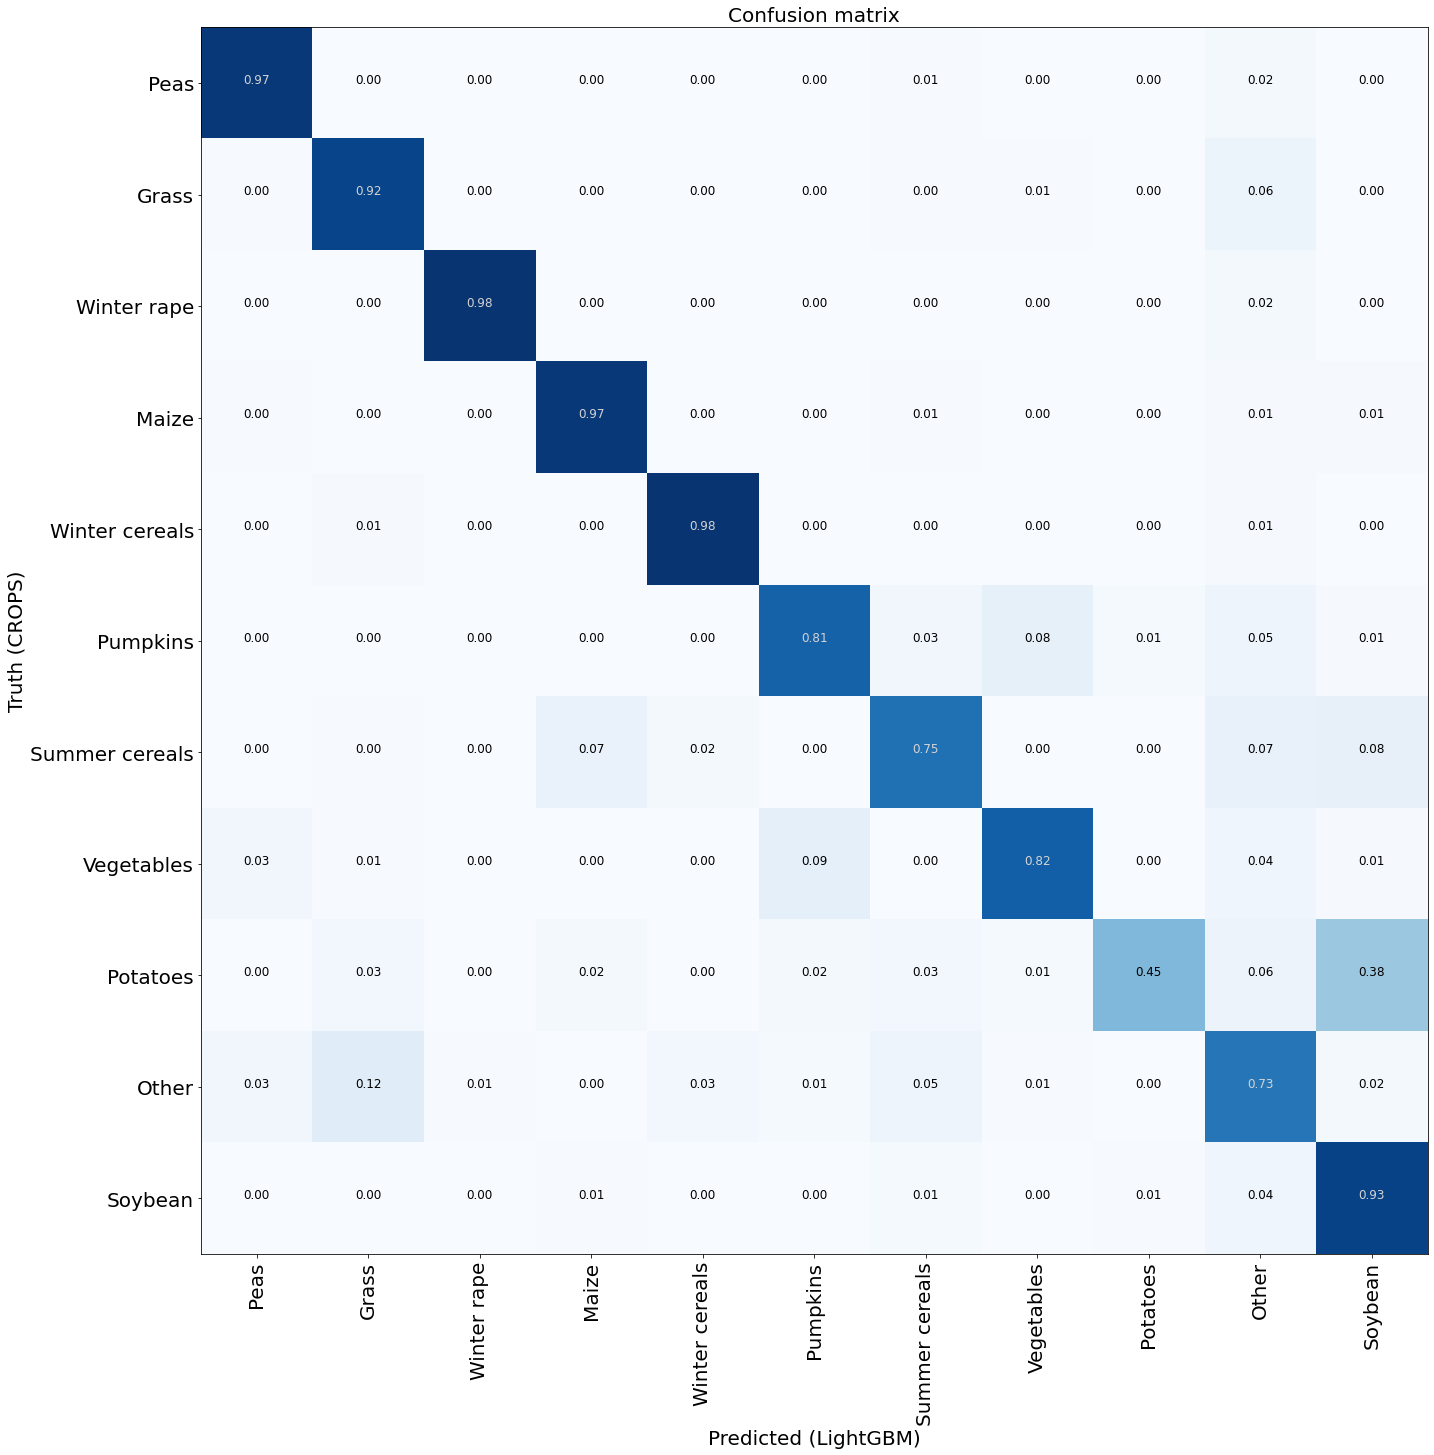

In [36]:
fig = plt.figure(figsize=(20, 20))
conf_matrix_gbm = metrics.confusion_matrix(rev_y_test, py_test_lgbm)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (CROPS)',
                      xlabel='Predicted (LightGBM)',
                      title='Confusion matrix');

### Plot the standard Confusion Matrix for TempCNN

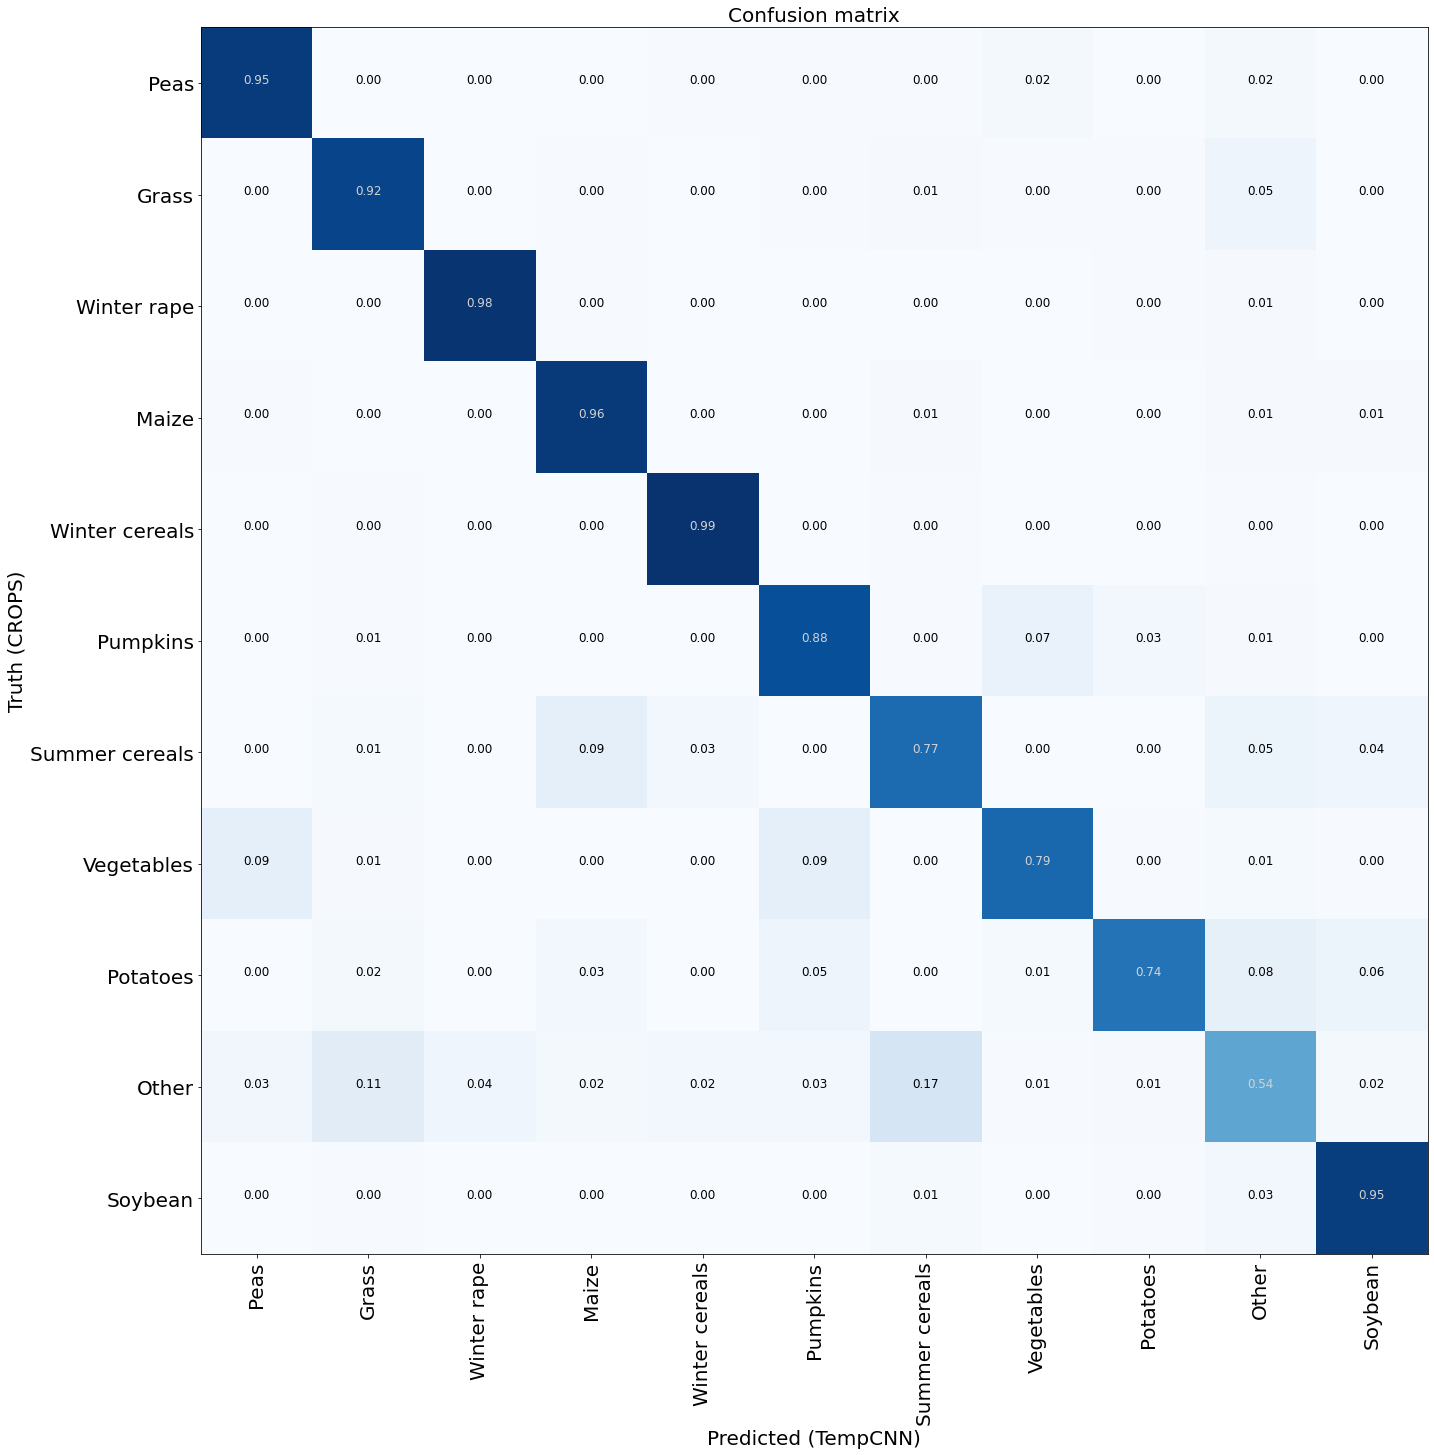

In [37]:
fig = plt.figure(figsize=(20, 20))
conf_matrix_gbm = metrics.confusion_matrix(rev_y_test, py_test_tcnn)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (CROPS)',
                      xlabel='Predicted (TempCNN)',
                      title='Confusion matrix');

The validation of the models shows that for most of the groups both perform very well. However, there seem to be differences in their confusion for certain classes:
* In this specific case orchards might catch your attention mostly. LightGBM performs worse than TempCNN. But more interesting than the overall accuracy is, that LightGBM classifies actual orchards as grass a lot (low recall) while, no other class is mistaken as orchards (high precision). In contrast TempCNN recognizes actual orchards well (high recall) but identifies acutal grass as orchards frequently (lower precision). Generally, confusion with grass class is not surprising, as there is a lot of it between the individual trees.
* There is also poor performance received for potatoes in both models as their cultivation practices are quite similar to peas.
* Poor performance for the group Other is expectable in consequence of its diverse class composition

### Most important features

The LightGBM model contains the information about feature importances. Let's check which features are most important for  classification.

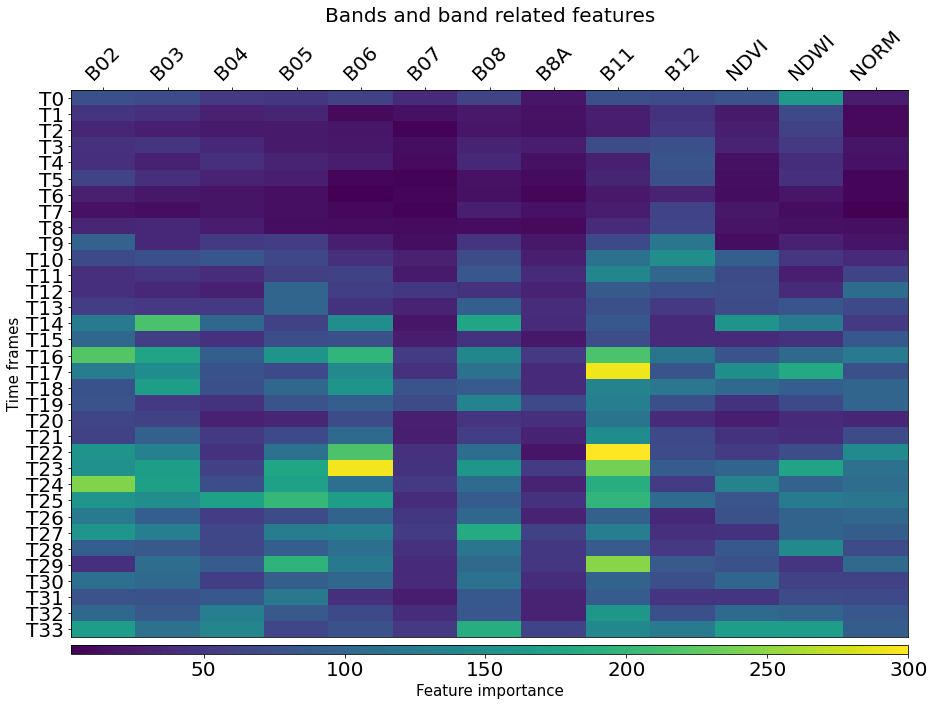

In [38]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)

timeframe_count = eopatch.data['FEATURES'].shape[0]
features_count = eopatch.data['FEATURES'].shape[3]

del eopatch

z = model_lgbm.feature_importances_.reshape((timeframe_count, features_count))

fnames = ['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12','NDVI','NDWI','NORM']

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(timeframe_count), ['T{}'.format(i) for i in range(timeframe_count)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=15)
plt.ylim(top=-0.5, bottom=timeframe_count - 0.5)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_label('Feature importance', fontsize=15)

As you can see, the most important features for LightGBM are recorded within the main growth period. Here different growing stages can be detected that constitute certain crop types. 

## Prediction

Now that both models have been validated, the remaining thing is to predict the whole AOI. As LightGBM receives higher overall accurays it is used for further predictions. If you are interested in a specific crop group TempCNN is outperforming LightGBM simply change the following configuration.

In [39]:
# swap commentation for using a different model

model = load_model(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id))) # load TempCNN model
# model = joblib.load(os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id))) # load LightGBM model

# load respective feature scaler
scaler = joblib.load(os.path.join(samples_path, 'Scaler_{}.bin'.format(grouping_id)))

In the following you define a workflow to make a prediction on the existing EOPatches. The EOTask accepts the features and the names for the labels. In addition you export GeoTIFF images of the prediction to easily access your visual results.

### Set up your 4. EOWorklow - Prediction

In [40]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(patch_path)

# TASK FOR PREDICTION
predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', scaler)

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'), image_dtype=np.int32)
tiff_location = predictions_path
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)
    
# TASK FOR SAVING
save = SaveTask(patch_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)


workflow = LinearWorkflow(load,
                          predict,
                          export_tiff,
                          save)

### Run fourth EOWorkflow

In [41]:
patch_list = get_patch_list(patch_path) # update patch list
    
# execute workflow
for patch_name in tqdm(patch_list):
    extra_param = {load: {'eopatch_folder': patch_name}, 
                   export_tiff: {'filename': '{}/prediction_{}.tiff'.format(predictions_path, patch_name)}, 
                   save: {'eopatch_folder': patch_name}}

    workflow.execute(extra_param)

  0%|          | 0/4 [00:00<?, ?it/s]

### EOPatch data visualization

Finishing the last processing step, let's have a look at the final EOPatch by executing
```
EOPatch.load(os.path.join(patch_path, 'eopatch_0_col-0_row-0')
```

You obtain the following structure which is extended by your predicted data stored as `LBL_GBM` in `mask_timeless.FeatureType`:


```
EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 1028, 1033, 13), dtype=float64)
    FEATURES_SAMPLED: numpy.ndarray(shape=(34, 6000, 1, 13), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LBL_GBM: numpy.ndarray(shape=(1028, 1033, 1), dtype=int64)
    LPIS_class_basic: numpy.ndarray(shape=(1028, 1033, 1), dtype=uint8)
    LPIS_class_basic_ERODED: numpy.ndarray(shape=(1028, 1033, 1), dtype=uint8)
    LPIS_class_basic_ERODED_SAMPLED: numpy.ndarray(shape=(6000, 1, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    LPIS_2018: geopandas.GeoDataFrame(columns=['geometry', 'FS_KENNUNG', 'SL_FLAECHE', 'ID', 'SNAR_BEZEI', 'DateImported', 'SNAR_BEZEI_NAME', 'CROP_ID', 'english', 'slovenian', 'latin', 'GROUP_1', 'GROUP_1_original', 'GROUP_1_ID'], length=4091, crs=EPSG:32633)
  }
  meta_info: {}
  bbox: BBox(((420862.3179607267, 5329537.336315366), (431194.28800678457, 5339817.792378783)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2018, 1, 6, 0, 0), ..., datetime.datetime(2018, 9, 27, 0, 0)], length=34
)
```

## Visualization of the results

### Visualize predicted EOPatch data

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


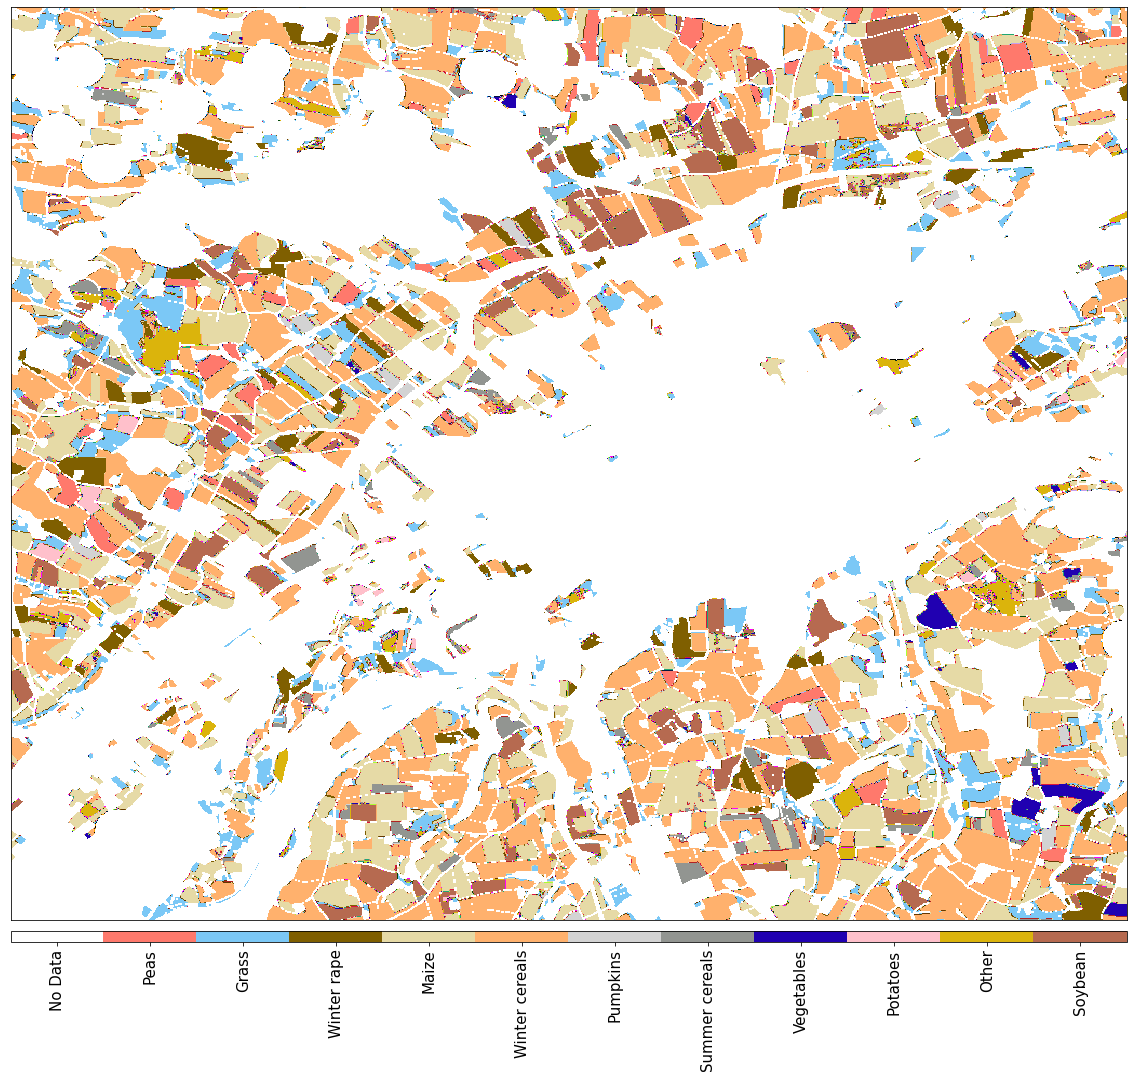

In [42]:
eopatch_name = 'eopatch_0_col-0_row-0' # get the name of the first newly created EOPatch
eopatch = EOPatch.load(os.path.join(patch_path, eopatch_name), lazy_loading=True)

# update colormap
cb_classes = np.unique(np.unique(eopatch.mask_timeless['LBL_GBM']))
custom_cmap = mpl.colors.ListedColormap([lpisclass_cmap.colors[i] for i in cb_classes])
custom_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, len(cb_classes), 1), custom_cmap.N)

# mask prediction - exclude pixel with no LPIS reference
labels = np.array(eopatch.mask_timeless['LPIS_class_{}'.format(grouping_id)])
mask = labels == 0
labelspred = np.array(eopatch.mask_timeless['LBL_GBM'])
LBL = np.ma.masked_array(labelspred, mask)

# plot figure
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(LBL.squeeze(), cmap=lpisclass_cmap, norm=lpisclass_norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('auto')

fig.subplots_adjust(wspace=0, hspace=0)

# plot colorbar
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=custom_norm, cmap=custom_cmap), 
                  orientation="horizontal", 
                  pad=0.01, 
                  aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks(range(len(cb_classes)))
cb.ax.set_xticklabels([class_names[i] for i in cb_classes], rotation=90, fontsize=15)
plt.show()

### Compare ground truth and prediction

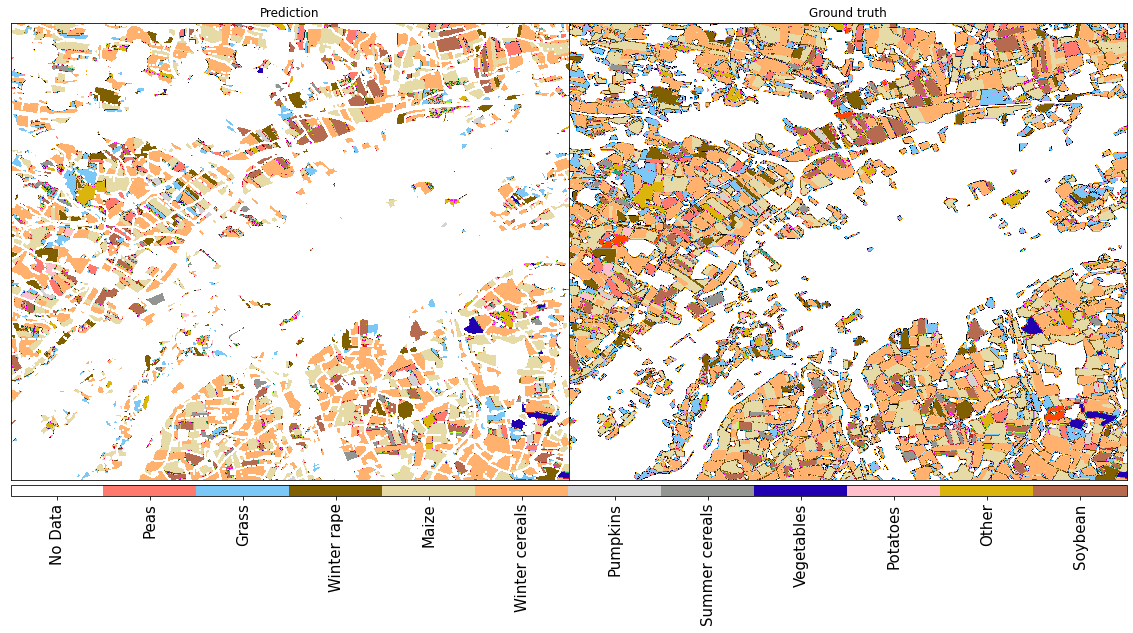

In [43]:
# mask prediction - exclude pixel with no LPIS reference
labels = np.array(eopatch.mask_timeless['LPIS_class_{}'.format(grouping_id)])
mask = labels == 0
labelspred = np.array(eopatch.mask_timeless['LBL_GBM'])
LBL = np.ma.masked_array(labelspred, mask)

fig, axes = plt.subplots(2,2,figsize=(20, 10))

# plot prediction
ax1 = plt.subplot(121)
im = ax1.imshow(LBL.squeeze(), cmap=lpisclass_cmap, norm=lpisclass_norm)
plt.title('Prediction')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect('auto')

# plot ground truth
ax2 = plt.subplot(122)
im = ax2.imshow(labels.squeeze(), cmap=lpisclass_cmap, norm=lpisclass_norm)
plt.title('Ground truth')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('auto')

axlist=[ax1,ax2]

fig.subplots_adjust(wspace=0, hspace=0)

# plot colorbar
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=custom_norm, cmap=custom_cmap), 
                  ax = axlist,
                  orientation="horizontal", 
                  pad=0.01, 
                  aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks(range(len(cb_classes)))
cb.ax.set_xticklabels([class_names[i] for i in cb_classes], rotation=90, fontsize=15)
plt.show()

### Close-up comparison

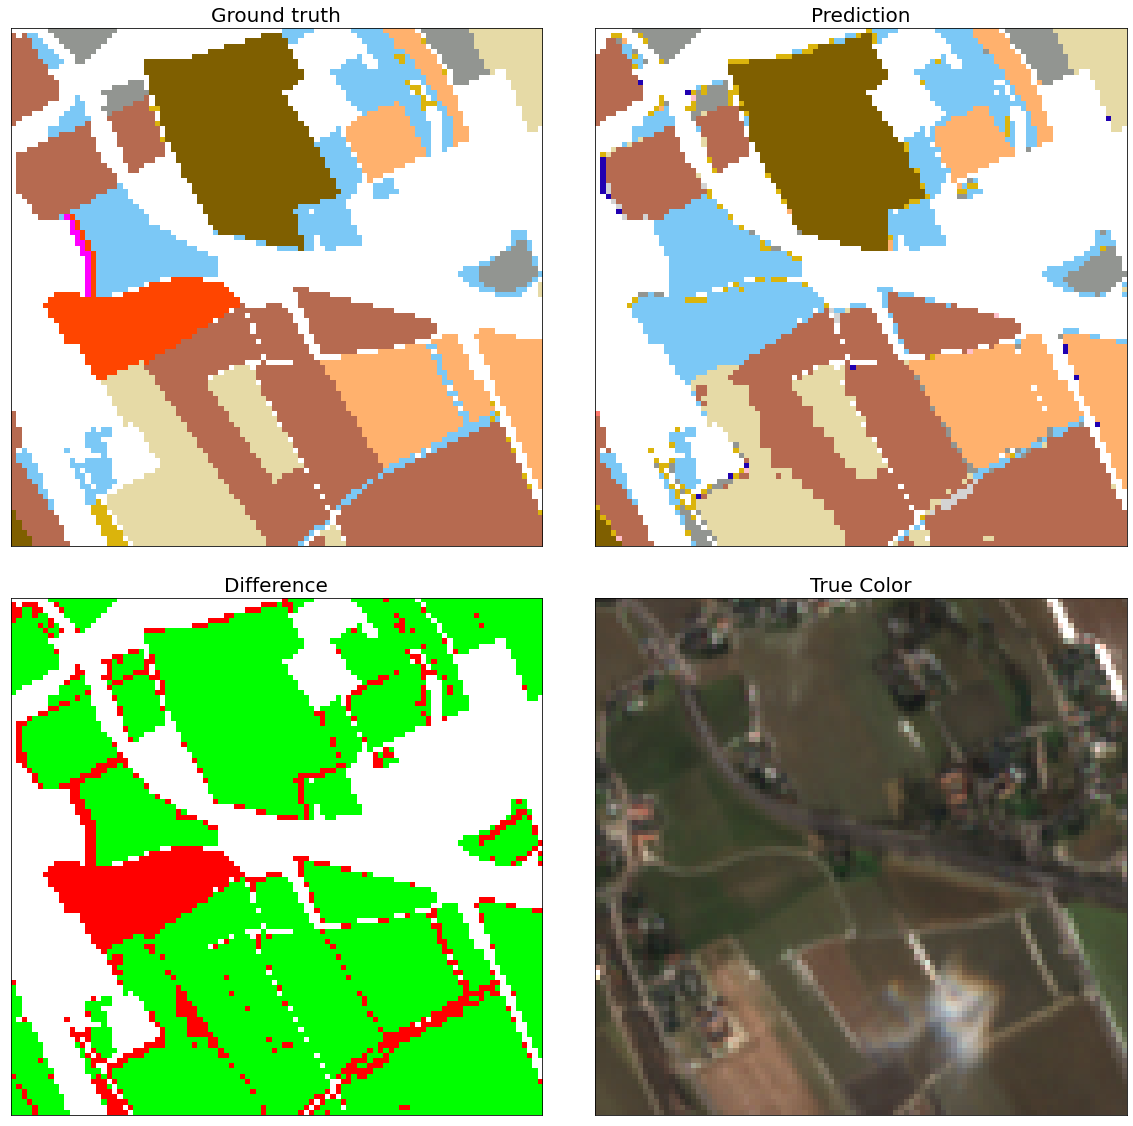

In [44]:
# create red-green colormap
colors = [(0, 1, 0), (1, 0, 0)]  # G -> R
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors)


fig = plt.figure(figsize=(20, 20))

inspect_size = 100

w, h = labels.squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
h_min = np.random.choice(range(h - inspect_size))

ax = plt.subplot(2, 2, 1)
plt.imshow(labels.squeeze()[w_min: w_min + inspect_size, h_min : h_min + inspect_size],
           cmap=lpisclass_cmap, norm=lpisclass_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Ground truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(LBL.squeeze()[w_min: w_min + inspect_size, h_min: h_min + inspect_size],
           cmap=lpisclass_cmap, norm=lpisclass_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect('auto')
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = LBL.squeeze() != labels.squeeze()
plt.imshow(mask[w_min: w_min + inspect_size, h_min: h_min + inspect_size], cmap=cm)
plt.xticks([])
plt.yticks([]);
ax.set_aspect('auto')
plt.title('Difference', fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['FEATURES'][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min: w_min + inspect_size, h_min: h_min + inspect_size])
plt.xticks([])
plt.yticks([]);
ax.set_aspect('auto')
plt.title('True Color', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)

As you can probably see in the randomly chosen section of the AOI there are certain patterns of misclassified pixels:
* There are complete fields mistaken as another crop group. In this case the algorithm got confused because of similar spectral characteristics. You already got an overview of the frequency and combination of those incidents in the evaluation part above.
* Misclassified single pixels are usually located at the border of the respective fields. Here the "mixed-pixel-problem" impacts the prediction results. For the modeling these pixels were excluded, as they may include spectral reflectance values of different vegetation types and thereby confuse the algorithm.

# Next steps

Now, after your first successful classification you are hooked? But the region around Wels in Austria was surprisingly not your actual AOI or you want to try other vegetation groupings? Then here are some suggestions on how you could proceed:
* **Customize configurations**

    The notebook offers various possibilities to change parameters and evaluate their effects. Simply enter the configuration section in the beginning and modify e.g. cloudcover thresholds or your sampling strategy.


* **Change the AOI within Austria**

    This would be the simplest case to apply. You just have to place a Shapefile or Geojson of your own AOI in the location of the "Area_AOI.geojson" from the example. The size and shape of the included polygon are irrelevant. 
    
    
* **Try alternative crop groupings**

    In order to regroup the LPIS classes you need to have a closer look at the two CSV files in the `GeneralData` folder. 
    * `at_lpis_2018_crop_to_group_mapping_basic.csv`: Here you can assign LPIS classes to different crop groups.\
       *_CROP_ID_* represents the respective LPIS class\
       *_GROUP_1_* represents the respective group you want a class in
    * `crop_group_1_definition_basic.csv`: Here you can combine or separate individual crop groups by assigning the respective ID.\
      *_GROUP_1_* again represents the groups\
      *_GROUP_1_ID_* represents the respective numeric ID
    
    
* **Apply the notebook to another country**

    Another country means different AOI plus different LPIS classes. 
    * The first requires no additional effort. Change your AOI file and run the processes. EO data is downloaded and processed exactly as in the example. 
    * But when it comes to the ground truth data, this is were things get tricky as you additionally need to customize the CSV grouping files for your specific country